In [1]:
# Special credit to Statsbomb for publicly releasing Bayer Leverkusen's 2023-2024 season data
# Load in the prebuilt packages which accesses APIs and libraries to streamline subsequent coding
!pip install statsbombpy
!pip install mplsoccer

In [2]:
from statsbombpy import sb
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations (though not used directly in this snippet)
from mplsoccer import Pitch, Sbopen, VerticalPitch  # For creating a soccer pitch and handling soccer data
import pandas as pd  # For working with dataframes
import matplotlib.colors as mcolors
import matplotlib.patches as patches

In [3]:
# When analyzing the entire seasonal data metrics, we instead use sb.competition_events(), NOTE: only desriptive arguments work here
all_events = sb.competition_events(
    country = "Germany",
    division = "1. Bundesliga",
    season = "2023/2024",
    gender = "male",
    split = True # Is a dictionary if split = True, as separate columns are created
    # If split = False, its a dataframe -> Useful for things like relationship between event types (Eg. pass and shots), all events by one player, EDA where everythings in one place
)

In [4]:
# Filter all shots
shots_df = pd.DataFrame(all_events["shots"])
shots_df = shots_df[shots_df["possession_team"] == "Bayer Leverkusen"]
shots_df = shots_df[shots_df["team"] == "Bayer Leverkusen"]

# Create new timestamp based on seconds 
shots_df["timestamp_seconds"] = shots_df["minute"] * 60 + shots_df["second"] 

shots_df = shots_df.sort_values(by = ["timestamp_seconds", "match_id"])
shots_df.reset_index(drop = True, inplace = True) 

In [5]:
print(all_events.keys())

dict_keys(['starting_xis', 'half_starts', 'passes', 'ball_receipts', 'carrys', 'pressures', 'miscontrols', 'dribbles', 'duels', 'interceptions', 'ball_recoverys', 'dispossesseds', 'blocks', 'foul_committeds', 'foul_wons', 'errors', 'shots', 'goal_keepers', 'injury_stoppages', 'referee_ball_drops', '50/50s', 'clearances', 'offsides', 'dribbled_pasts', 'player_offs', 'player_ons', 'half_ends', 'substitutions', 'bad_behaviours', 'tactical_shifts', 'shields', 'own_goal_fors', 'own_goal_againsts'])


In [6]:
# TURNOVERS
# Combine all events which result in direct possession switches to Bayer Leverkusen from open play

miscontrols_df = pd.DataFrame(all_events["miscontrols"])
dispossesseds_df = pd.DataFrame(all_events["dispossesseds"])
interceptions_df = pd.DataFrame(all_events["interceptions"])
duels_df = pd.DataFrame(all_events["duels"])
fiftyfifties_df = pd.DataFrame(all_events["50/50s"])
ball_recoverys_df = pd.DataFrame(all_events["ball_recoverys"])
dribbles_df = pd.DataFrame(all_events["dribbles"])

# Filter failed duels, 50/50s, ball recoverys, dribbles which result in succesful possession switches where the ball stays in play
lost_duels_df = duels_df[duels_df["duel_outcome"] == "Lost In Play"]
fiftyfifties_df["outcome_name"] = fiftyfifties_df["50_50"].apply( # Special case -> need to extract the name field from nested dictionary, make new column for outcome
    lambda x: x["outcome"]["name"] if pd.notnull(x) else None
)
lost_fiftyfifties_df = fiftyfifties_df[fiftyfifties_df["outcome_name"] == "Lost"]
lost_ball_recoverys_df = ball_recoverys_df[(ball_recoverys_df["ball_recovery_recovery_failure"] == True) & (ball_recoverys_df["out"] != True)]
lost_dribbles_df = dribbles_df[dribbles_df["dribble_outcome"] == "Incomplete"]

# Filter for succesful interceptions
won_interceptions_df = interceptions_df[(interceptions_df["interception_outcome"] == "Won") | (interceptions_df["interception_outcome"] == "Success In Play")]

# Add turnover type to each type, for usage later
lost_duels_df = lost_duels_df.assign(turnover_type="lost_duel")
fiftyfifties_df = fiftyfifties_df.assign(turnover_type="fiftyfifty")
lost_ball_recoverys_df = lost_ball_recoverys_df.assign(turnover_type="lost_ball_recovery")
lost_dribbles_df = lost_dribbles_df.assign(turnover_type="lost_dribble")
won_interceptions_df = won_interceptions_df.assign(turnover_type="won_interception")
miscontrols_df = miscontrols_df.assign(turnover_type="miscontrol")
dispossesseds_df = dispossesseds_df.assign(turnover_type="dispossesseds")

# Concat with filtered conditions, adding in dispossessions and miscontrols
all_turnover_events_df = pd.concat([
    lost_duels_df,
    fiftyfifties_df,
    lost_ball_recoverys_df,
    lost_dribbles_df,
    won_interceptions_df,
    miscontrols_df,
    dispossesseds_df
])

# Create new timestamp based on seconds 
all_turnover_events_df["timestamp_seconds"] = all_turnover_events_df["minute"] * 60 + all_turnover_events_df["second"] 

# Invert the x and y values of turnover location, to sync with Bayer Leverkusen's perspective
all_turnover_events_df["location"] = all_turnover_events_df["location"].apply(
    lambda loc: [120 - loc[0], 80 - loc[1]] if isinstance(loc, list) else loc
)

all_turnover_events_df = all_turnover_events_df.sort_values(by=["timestamp_seconds", "match_id"])
all_turnover_events_df.reset_index(drop = True, inplace = True) 


# Filter for turnover cases where opposition team has possession initially and turns over to Bayer (gaining possession)
turnover_events_df = all_turnover_events_df[all_turnover_events_df["possession_team"] != "Bayer Leverkusen"].copy()
turnover_events_df = turnover_events_df[turnover_events_df["team"] != "Bayer Leverkusen"]
turnover_events_df = turnover_events_df.sort_values(by=["timestamp_seconds", "match_id"])
turnover_events_df.reset_index(drop = True, inplace = True) 

# Filter for turnover cases where Bayer has possession initially and turns over to the opposing team (losing possession)
opp_turnover_events_df = all_turnover_events_df[all_turnover_events_df["possession_team"] == "Bayer Leverkusen"].copy()
opp_turnover_events_df = opp_turnover_events_df[opp_turnover_events_df["team"] == "Bayer Leverkusen"]
opp_turnover_events_df = opp_turnover_events_df.sort_values(by=["timestamp_seconds", "match_id"])
opp_turnover_events_df.reset_index(drop = True, inplace = True) 

In [7]:
# TURNOVER SHOTS
# Shots that occur within x seconds of a turnover event for Bayer Leverkusen, by merging on match_id 
turnover_shots_df = pd.merge(
    turnover_events_df,
    shots_df,
    on = ["match_id"],
    suffixes = ('_turnover', '_shot'),
    how = 'inner'# Not left join as we don't include the matches with invalid or no shots in a game
)


turnover_shots_df = turnover_shots_df[turnover_shots_df["team_turnover"] != "Bayer Leverkusen"]

# Sort by match_id and turnover timestamp, so we can find the last turnover before a shot -> Important that match_id is sorted first
turnover_shots_df = turnover_shots_df.sort_values(by = ["match_id", "timestamp_seconds_shot"])


def get_last_turnover(group): # Group is the subset of the Dataframe containing all the rows (turnovers and shots) for a single match
    group['last_turnover_before_shot'] = group.apply(
        lambda row: group[group['timestamp_seconds_turnover'] < row['timestamp_seconds_shot']]['timestamp_seconds_turnover'].max(),
        axis = 1 
    )
    return group

# Apply the function to each match_id group
turnover_shots_df = turnover_shots_df.groupby('match_id').apply(get_last_turnover) # Ensures we apply the function SEPARATELY to each match

# Now filter to keep only the rows where the turnover timestamp matches the last turnover before the shot, hence dropping all the non-last turnovers connected to the same shot
turnover_shots_df = turnover_shots_df[turnover_shots_df['timestamp_seconds_turnover'] == turnover_shots_df['last_turnover_before_shot']]

# Drop the helper column for clarity -> The values are the exact same as the timestamp_seconds_turnover column atm
turnover_shots_df = turnover_shots_df.drop(columns = ["last_turnover_before_shot"])

turnover_shots_df.reset_index(drop = True, inplace = True) 

In [8]:
# Function which plots the shots and associated turnover location within x seconds of regaining possession 
def plot_turnover_shots(df, df_name):
    # Create a pitch
    pitch = Pitch(line_color='white', pitch_color='black')
    
    # Create figure
    fig, ax = pitch.draw(figsize=(12, 8)) # Matches statsbomb's locational data of 120 x 80 (aspect ratio)
    
    # Define event types and their corresponding colors
    event_types = {
        "Goal": ("green", "Goal"),
        "Shot (No goal)": ("red", "Shot (No goal)"),
        "Turnover (led to Goal)": ("lime", "Turnover (led to Goal)"),
        "Turnover (led to Shot)": ("pink", "Turnover (led to Shot)")
    }
    
    # Add legend entries first (ensures they always appear)
    for color, label in event_types.values():
        pitch.scatter([], [], ax = ax, color = color, s = 100, edgecolors = 'white', label = label)
    
    # Plot resulting shots and highlight goals
    for i, row in df.iterrows():
        if isinstance(row["location_shot"], list) and len(row["location_shot"]) == 2:
            x, y = row["location_shot"]
            color, _ = event_types["Goal"] if row["shot_outcome"] == "Goal" else event_types["Shot (No goal)"]
            pitch.scatter(x, y, ax = ax, color = color, s = 100, edgecolors = 'white')

    # Plot turnovers leading to shots
    for i, row in df.iterrows():
        if isinstance(row["location_turnover"], list) and len(row["location_turnover"]) == 2:
            x, y = row["location_turnover"]
            color, _ = event_types["Turnover (led to Goal)"] if row["shot_outcome"] == "Goal" else event_types["Turnover (led to Shot)"]
            pitch.scatter(x, y, ax = ax, color = color, s = 100, edgecolors = 'white')

    # Add title and legend
    plt.title(f"{df_name} Following Turnover Events by Bayer Leverkusen", fontsize = 20)
    plt.legend(loc = 'upper left')
    
    plt.show()


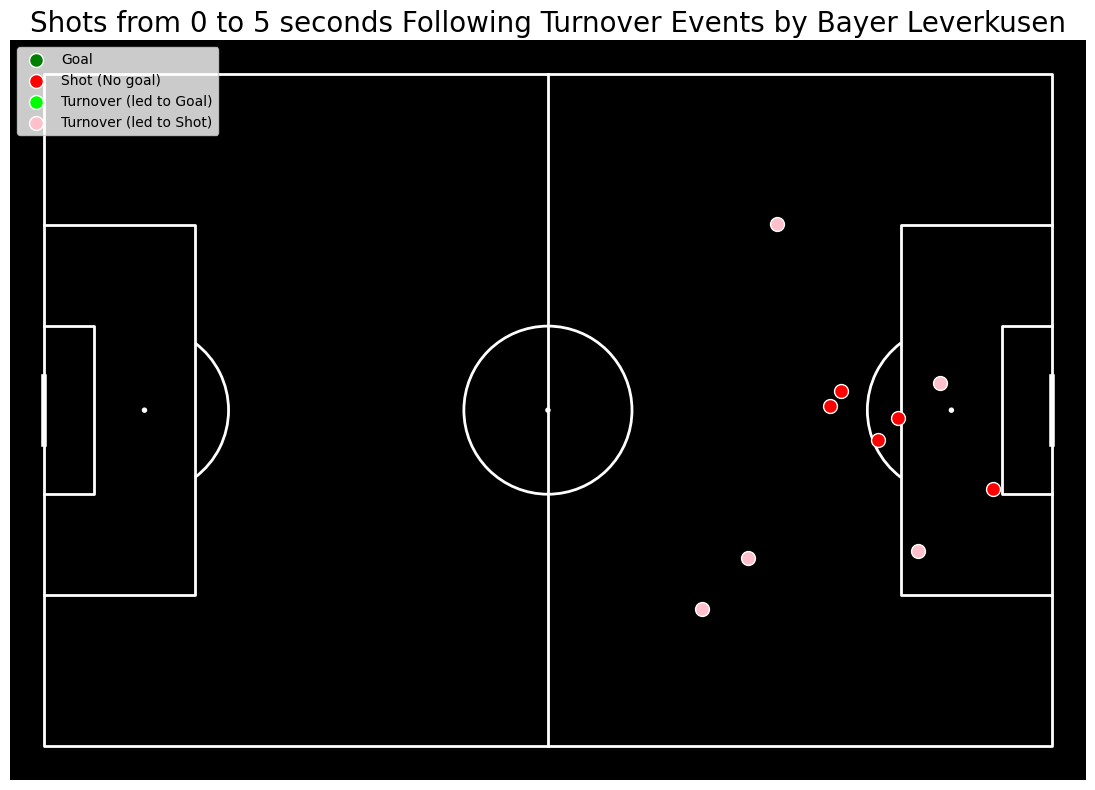

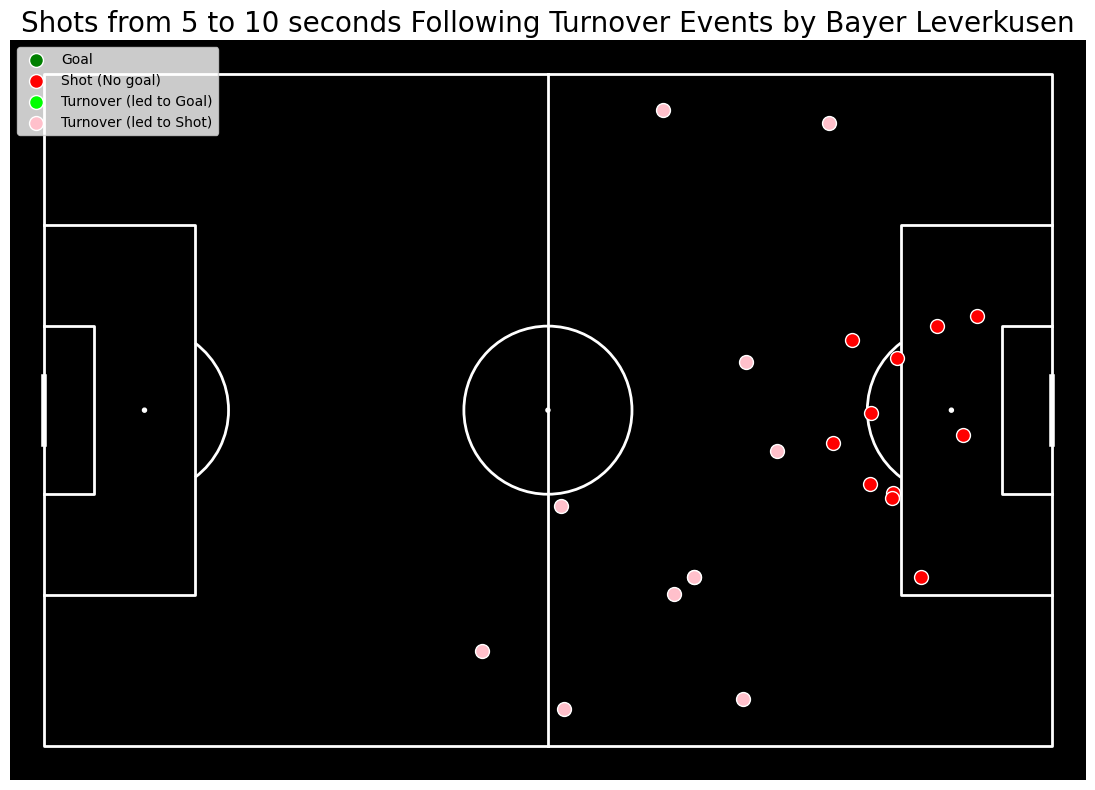

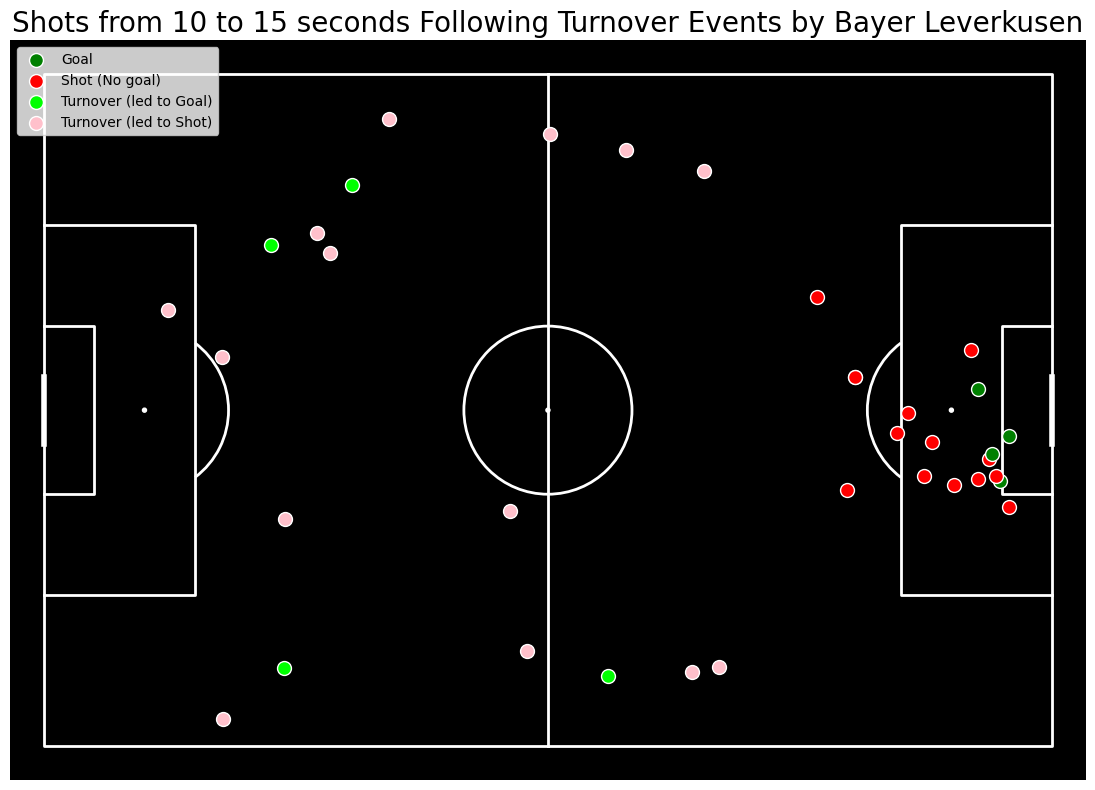

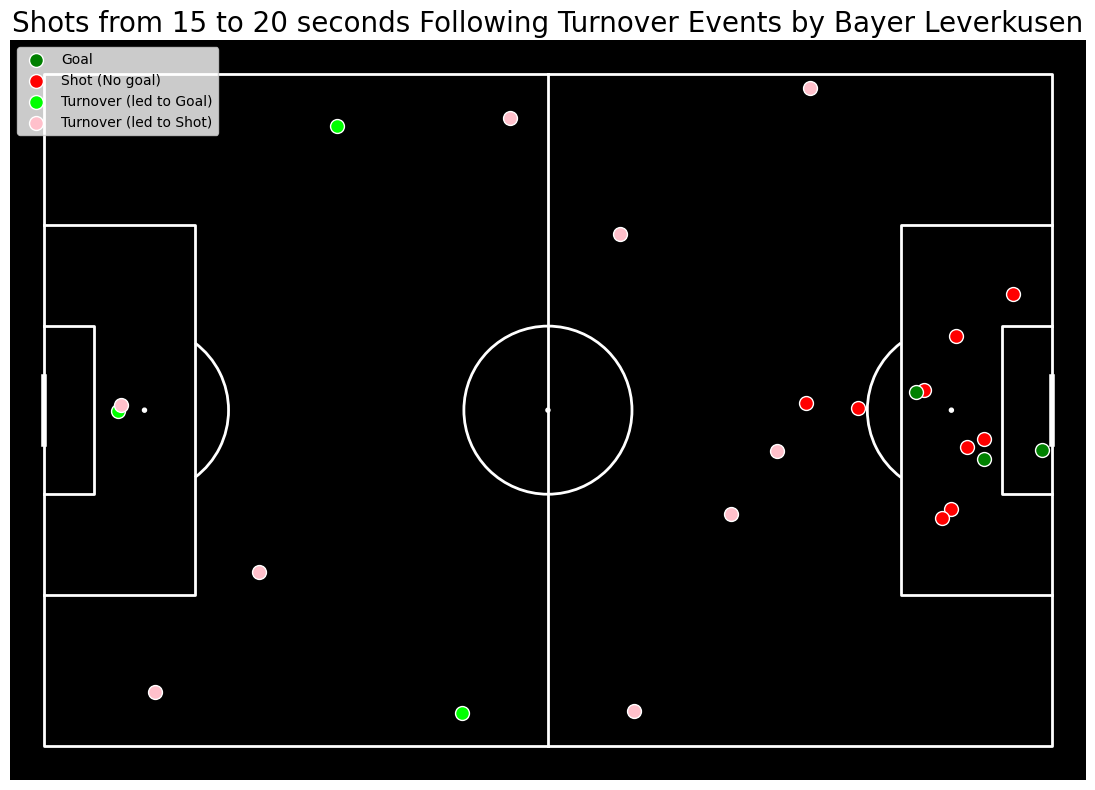

In [9]:
# Calculate time difference from turnover to shot, as new column
turnover_shots_df["time_diff"] = turnover_shots_df["timestamp_seconds_shot"] - turnover_shots_df["timestamp_seconds_turnover"] 

# Filter for shots within 5 seconds of a turnover
shots_from_0_to_5sec = turnover_shots_df[
    (turnover_shots_df["time_diff"] >= 0) & (turnover_shots_df["time_diff"] < 5)
]
shots_from_0_to_5sec.reset_index(drop = True, inplace = True)
    
# Filter for shots from 5 to 10 seconds of a turnover
shots_from_5_to_10sec = turnover_shots_df[
    (turnover_shots_df["time_diff"] >= 5) & (turnover_shots_df["time_diff"] < 10)
]
shots_from_5_to_10sec.reset_index(drop = True, inplace = True)

# Filter for shots from 10 to 15 seconds of a turnover
shots_from_10_to_15sec = turnover_shots_df[
    (turnover_shots_df["time_diff"] >= 10) & (turnover_shots_df["time_diff"] < 15)
]
shots_from_10_to_15sec.reset_index(drop = True, inplace = True)

# Filter for shots from 15 to 20 seconds of a turnover
shots_from_15_to_20sec = turnover_shots_df[
    (turnover_shots_df["time_diff"] >= 15) & (turnover_shots_df["time_diff"] < 20)
]
shots_from_15_to_20sec.reset_index(drop = True, inplace = True)


plot_turnover_shots(shots_from_0_to_5sec, "Shots from 0 to 5 seconds")
plot_turnover_shots(shots_from_5_to_10sec, "Shots from 5 to 10 seconds")
plot_turnover_shots(shots_from_10_to_15sec, "Shots from 10 to 15 seconds")
plot_turnover_shots(shots_from_15_to_20sec, "Shots from 15 to 20 seconds")

# shots_from_10_to_15sec[shots_from_10_to_15sec['shot_outcome'] == "Goal"][['position_turnover','location_turnover', 'location_shot', 'team_turnover', 'minute_turnover', 'second_turnover']]

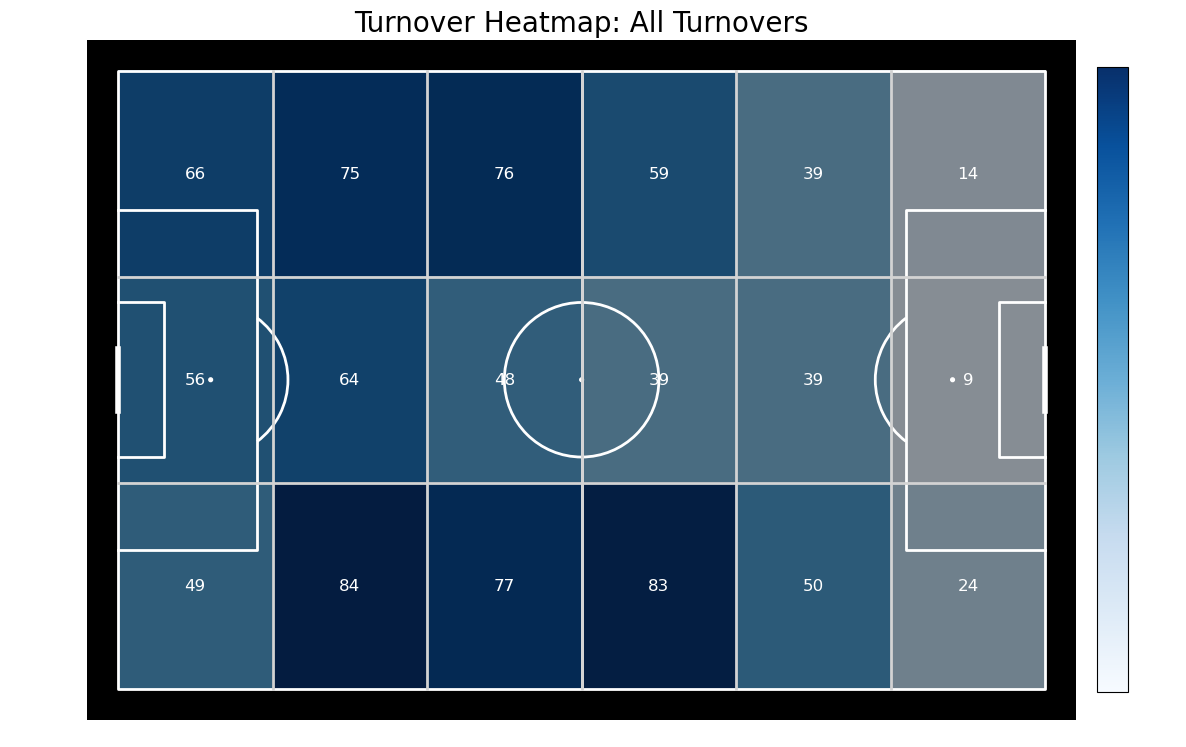

In [10]:
# TURNOVER HEATMAP
def plot_turnover_heatmap(df, df_name):
    # Initialize the pitch
    pitch = Pitch(line_color = 'white', pitch_color = 'black')  
    fig, ax = pitch.draw(figsize = (12, 8))

    # StatsBomb pitch dimensions
    pitch_length = 120
    pitch_width = 80

    # Define 6x3 zones (18 zones)
    num_horizontal = 6  
    num_vertical = 3    
    zone_length = pitch_length / num_horizontal
    zone_width = pitch_width / num_vertical

    # Create a 2D array (matrix) filled with zeros initially to store turnover counts
    turnover_counts = np.zeros((num_vertical, num_horizontal))

    # Count turnovers per zone
    for _, row in df.iterrows():
        if isinstance(row["location"], list) and len(row["location"]) == 2:
            x, y = row["location"]

            # Determine zone index
            x_zone = int(x // zone_length)
            y_zone = int(y // zone_width)

            # Ensure within bounds
            x_zone = min(x_zone, num_horizontal - 1)
            y_zone = min(y_zone, num_vertical - 1)

            # Store in correct orientation
            turnover_counts[y_zone, x_zone] += 1

    # Get the max turnover count
    max_count = turnover_counts.max()

    # Fix: Explicitly normalize colormap so heatmap and color bar match
    cmap = plt.cm.Blues
    norm = mcolors.Normalize(vmin = 0, vmax = max_count)

    # Use imshow to overlay the heatmap while keeping pitch markings visible
    heatmap = ax.imshow(turnover_counts, cmap = cmap, alpha = 0.6, 
                        extent = [0, pitch_length, 0, pitch_width], origin = 'lower', 
                        norm = norm)  

    # Use `ScalarMappable` so the color bar is perfectly in sync
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])  # This prevents an unnecessary warning

    # Add a color bar with correct scaling
    cbar = fig.colorbar(sm, ax = ax, fraction = 0.03, pad = 0.02)
    cbar.set_label("Turnover Count", fontsize = 12, color = 'white')
    cbar.ax.yaxis.set_tick_params(color = 'white')
    plt.setp(cbar.ax.get_yticklabels(), color = "white")  

    # Ensure color bar max matches `max_count`
    cbar.set_ticks(np.linspace(0, max_count, num = 5, dtype = int))  

    # Add grid lines over the zones with neutral gray color and proper placement
    for x in range(1, num_horizontal):
        ax.plot([x * zone_length, x * zone_length], [0, pitch_width], color = 'lightgray', lw = 2)
    for y in range(1, num_vertical):
        ax.plot([0, pitch_length], [y * zone_width, y * zone_width], color = 'lightgray', lw = 2)

    # Add turnover count as text in each zone
    for x in range(num_horizontal):
        for y in range(num_vertical):
            text_x_pos = (x * zone_length) + (zone_length / 2)
            text_y_pos = (y * zone_width) + (zone_width / 2)
            count = turnover_counts[y, x]
            ax.text(text_x_pos, text_y_pos, int(count), ha = 'center', va = 'center', color = 'white', fontsize = 12)

    # Add a total turnovers label as header
    total_turnovers = turnover_counts.sum()
    ax.text(0.5, pitch_width + 5, f"Total Turnovers: {int(total_turnovers)}", 
            ha = 'center', va = 'center', color = 'white', fontsize = 14, fontweight = 'bold')

    # Add title
    plt.title(f"Turnover Heatmap: {df_name}", fontsize = 20, color = 'black')

    plt.show()

plot_turnover_heatmap(turnover_events_df, "All Turnovers")


In [11]:
# BALL PROGRESSION

passes_df = pd.DataFrame(all_events["passes"])
carrys_df = pd.DataFrame(all_events["carrys"])

# Filter only successful passes
passes_df = passes_df[passes_df["pass_outcome"] != "Incomplete"]

# Ensure only Bayer Leverkusen passes and carries
passes_df = passes_df[passes_df["possession_team"] == "Bayer Leverkusen"]
passes_df = passes_df[passes_df["team"] == "Bayer Leverkusen"]

carrys_df = carrys_df[carrys_df["possession_team"] == "Bayer Leverkusen"]
carrys_df = carrys_df[carrys_df["team"] == "Bayer Leverkusen"]

# Create new timestamp column in seconds
carrys_df["timestamp_seconds"] = carrys_df["second"] + carrys_df["minute"] * 60
passes_df["timestamp_seconds"] = passes_df["second"] + passes_df["minute"] * 60

# Concatenate all ball progression events
progression_events_df = pd.concat([
    passes_df,
    carrys_df
])

# Reset index to ensure there are no duplicate labels
progression_events_df.reset_index(drop=True, inplace=True)

# Create a unified column for progression end location
progression_events_df["progression_end_location"] = (
    progression_events_df["carry_end_location"].combine_first(progression_events_df["pass_end_location"])
)

progression_events_df = progression_events_df.sort_values(by = ["timestamp_seconds", "match_id"])

# Filter for end locations of ball progression in the final sixth
progression_events_final_sixth_df = progression_events_df[
    progression_events_df["progression_end_location"].apply(lambda row: isinstance(row, list) and row[0] >= 100)
]

# FINAL SIXTH TURNOVER
progression_events_final_sixth_df = progression_events_final_sixth_df.sort_values(by=["timestamp_seconds", "match_id"], ascending=True)
turnover_events_df = turnover_events_df.sort_values(by=["timestamp_seconds", "match_id"], ascending=True)

turnover_events_df.reset_index(drop = True, inplace = True)
progression_events_final_sixth_df.reset_index(drop = True, inplace = True)

# merge_asof is the most efficient way to do one to nearest matching (instead of the covoluted merge -> group_by -> apply sequence), however
# a key limitation is that it doesn't naturally keep the "on" data of the right table  ... hence we need to manually save the timestamps of the turnovers

# Rename the timestamp column in both before merge_asof
turnover_events_df = turnover_events_df.rename(columns={"timestamp_seconds": "timestamp_seconds_turnover"})
progression_events_final_sixth_df = progression_events_final_sixth_df.rename(columns={"timestamp_seconds": "timestamp_seconds_progression"})

turnover_progression_final_sixth_df = pd.merge_asof(
    progression_events_final_sixth_df,
    turnover_events_df,
    left_on="timestamp_seconds_progression",
    right_on = "timestamp_seconds_turnover",
    by = "match_id",
    direction = "backward",
    suffixes = ("_progression", "_turnover")
)

In [12]:
def gradient_colorbar(fig, ax, max_progressions):
    # Gradient 
    cmap = plt.colormaps.get_cmap('Purples') 
    norm = mcolors.Normalize(vmin = 0, vmax = max_progressions)  
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])

    # Color bar 
    cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', shrink = 0.7, ticks = np.linspace(0, max_progressions, 5)) 
    cbar.set_label('Number of Progressions')  

    # Adds a rectangle patch to show final sixth region
    final_sixth_rect = patches.Rectangle((100, 0), 20, 80, linewidth = 0, edgecolor = 'none', facecolor = 'aqua', alpha = 0.3, zorder = 0)
    ax.add_patch(final_sixth_rect)
    return cmap, norm


In [13]:
def plot_progressions_final_sixth(pitch, fig, ax, match_df, previous_x, previous_y, progression_counter, max_progressions, cmap, norm):
     for i, row in match_df.iterrows():
        if isinstance(row["location"], list) and len(row["location"]) == 2:
            x_current, y_current = row["location"]
            progression_index = min(progression_counter, max_progressions) 
            color = cmap(norm(progression_index))  

            if row["type"] == "Carry":
                    pitch.lines(previous_x, previous_y, x_current, y_current,
                                ax = ax, color = 'lime', lw = 1, zorder = 1, linestyle = '-.')
            else:  # Type is pass
                pitch.lines(previous_x, previous_y, x_current, y_current,
                            ax = ax, color = 'orange', lw = 1, zorder = 1, linestyle = '--')
            # Check if the current progression is in the final sixth
            if x_current >= 100:
                pitch.scatter(x_current, y_current, ax = ax, color = color, s = 100, edgecolors = 'white', zorder = 2) # bigger dots
                break 
            else:
                # Update pvious location for the next iteration
                previous_x, previous_y = x_current, y_current
                pitch.scatter(x_current, y_current, ax = ax, color = color, s = 50, edgecolors = 'white', zorder = 2) 

            progression_counter += 1  # Increment the progress

# Function which plots the turnover locations with subsequent progressions until it enters final sixth, subsequent progressions will increase in 
# color gradient, going from a white dot for the original turnover, becoming more and more purple based on the number of subsequent progressions.
# Each progression, passes are mapped from one progression to the next with a dashed lines. Carrys are mapped with a dash dot line.
def plot_turnover_progression(df, df_name):
    pitch = Pitch(line_color = 'white', pitch_color = 'black')
    fig, ax = pitch.draw(figsize = (12, 8))

    # Legend
    event_types = {
        "Progression": ("rebeccapurple", "Progression"), 
        "Turnover": ("pink", "Turnover"),  
        "Carry": ("lime", "Carry"), 
        "Pass": ("orange", "Pass")    
    }
    for color, label in event_types.values(): # Unpacking the event_type tuple above for the legend, row by row
        pitch.scatter([], [], ax = ax, color = color, s = 100, edgecolors = 'white', label = label)

    max_progressions = 50
    cmap, norm = gradient_colorbar(fig, ax, max_progressions) 
    
    for match_id, match_df in df.groupby("match_id"):
        # Plot turnover points and set it as the starting position
        turnover_location = match_df["location_turnover"].iloc[0]
        if isinstance(turnover_location, list) and len(turnover_location) == 2:
            x_turnover, y_turnover = turnover_location
            pitch.scatter(x_turnover, y_turnover, ax = ax, color = 'pink', s = 50, edgecolors = 'white', zorder = 3)  

            progression_counter = 0  
            previous_x, previous_y = x_turnover, y_turnover

            plot_progressions_final_sixth(pitch, fig, ax, match_df, previous_x, previous_y, progression_counter, max_progressions, cmap, norm)

    # Add title and legend
    plt.title(f"Progressions Following Turnovers in {df_name}", fontsize=20)
    plt.legend(loc='upper left')
    plt.show()

In [14]:
# PROGRESSIONS BETWEEN FINAL SIXTH TURNOVERS
# Merge because we need to access all the progression events, linking it to the turnover -> final sixth progression pairs
progression_merged_df = pd.merge(
    progression_events_df,
    turnover_progression_final_sixth_df,
    on = 'match_id',
    how = 'inner',
    suffixes = ('', '_turnover')
)

# Filter for events within the turnover-progression time range
progression_merged_df = progression_merged_df[
    (progression_merged_df["timestamp_seconds"] > progression_merged_df["timestamp_seconds_turnover"]) &
    (progression_merged_df["timestamp_seconds"] <= progression_merged_df["timestamp_seconds_progression"])
]

# Select relevant columns and reset index
progression_merged_df = progression_merged_df[[
    "match_id", "type", "location", "location_turnover", "progression_end_location",
    "timestamp_seconds", "timestamp_seconds_turnover", "timestamp_seconds_progression", "player"
]]

progression_merged_df = progression_merged_df.sort_values(["timestamp_seconds", "match_id"])
progression_merged_df.reset_index(drop=True, inplace=True)

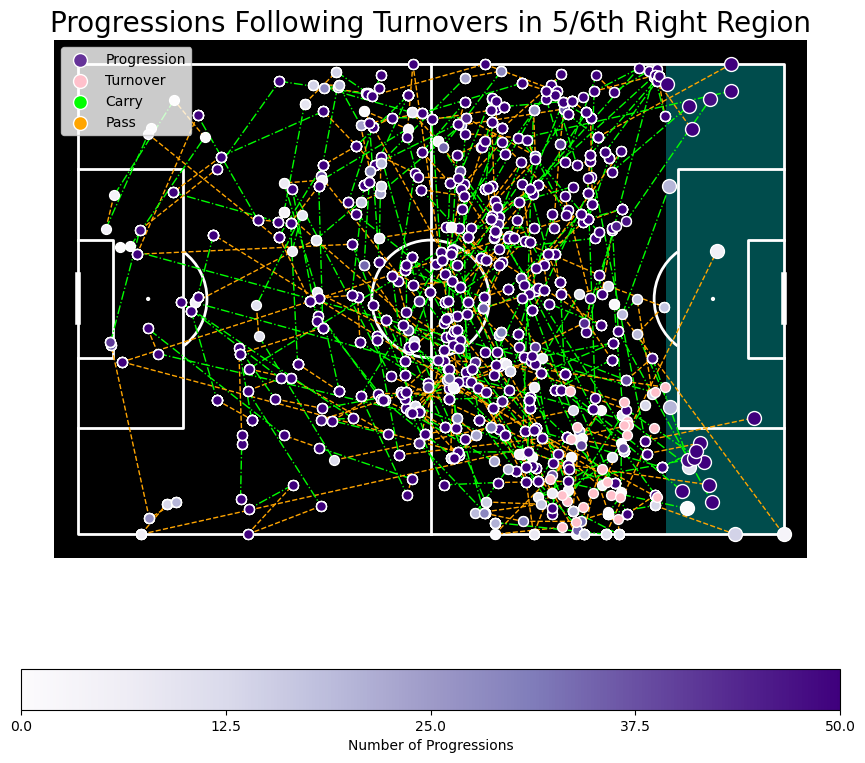

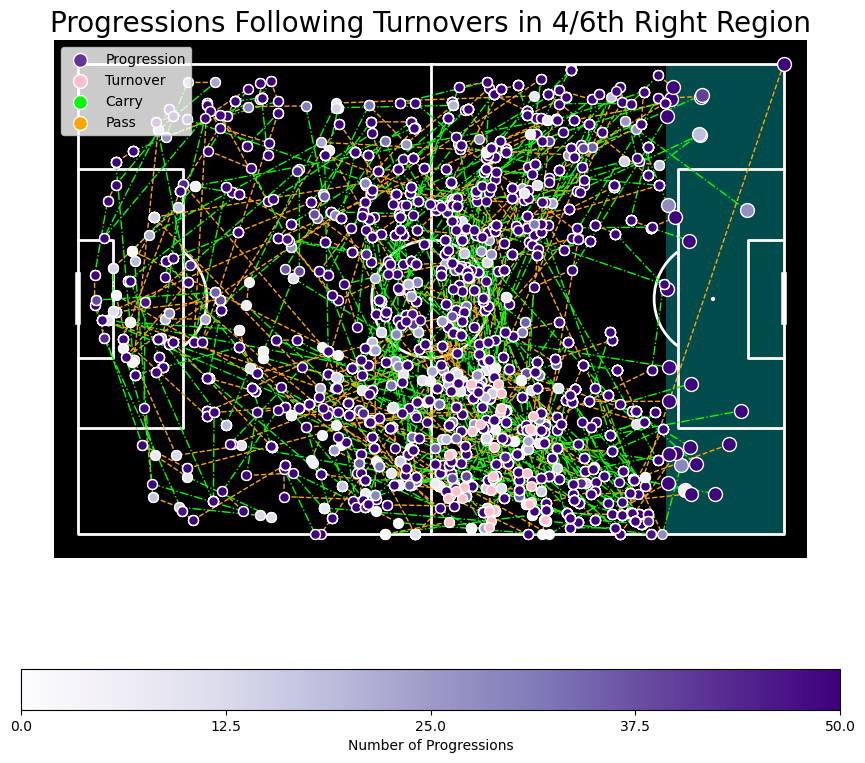

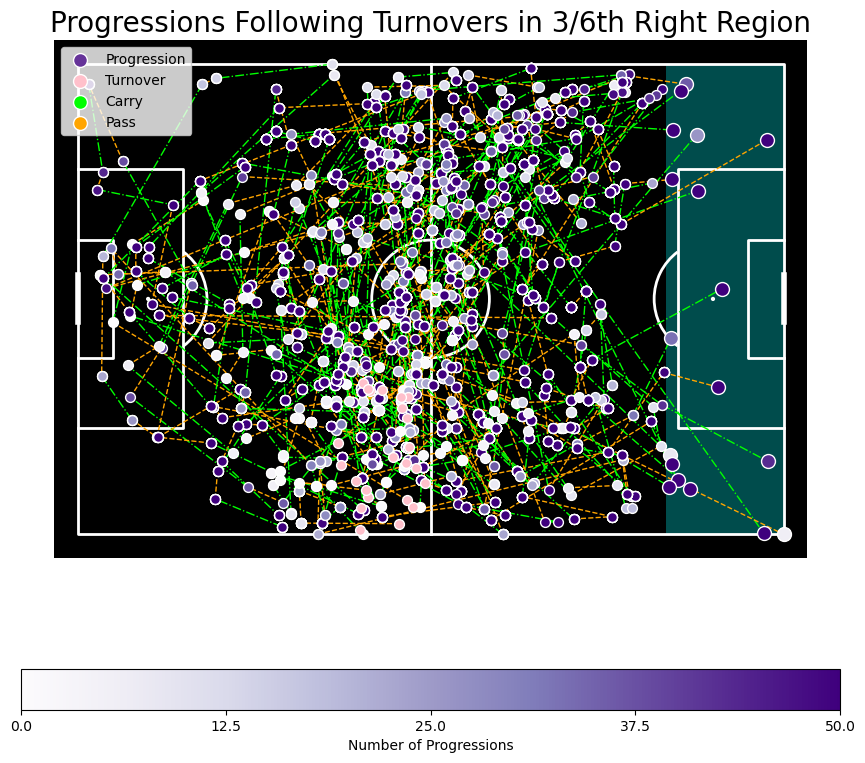

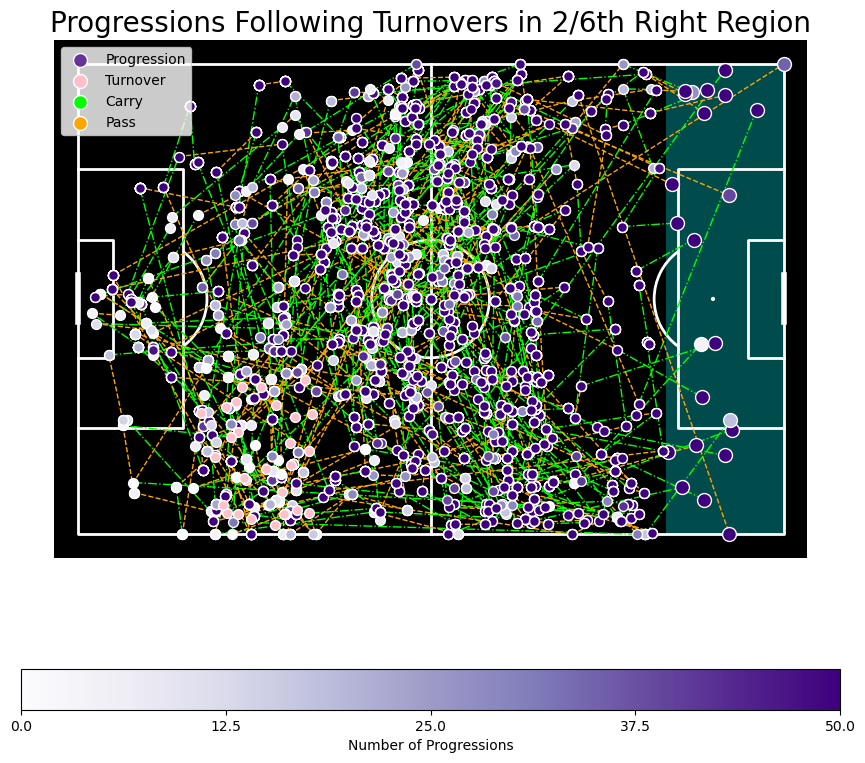

In [15]:
# SPECIFIC REGIONS OF INTEREST (High Turnover)

# Apply 5/6ths Right Region Filter 
progression_5_6th_right = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (80 <= row[0] < 100) and
                    (160 / 3 <= row[1] < 80)
    )
]

plot_turnover_progression(progression_5_6th_right, "5/6th Right Region")

# Apply 4/6ths Right Region Filter 
progression_4_6th_right = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (60 <= row[0] < 80) and
                    (160 / 3 <= row[1] < 80)
    )
]

plot_turnover_progression(progression_4_6th_right, "4/6th Right Region")


# Apply 3/6ths Right Region Filter 
progression_3_6th_right = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (40 <= row[0] < 60) and
                    (160/3 <= row[1] < 80)
    )
]

plot_turnover_progression(progression_3_6th_right, "3/6th Right Region")

# Apply 2/6ths Right Region Filter 
progression_2_6th_right = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (20 <= row[0] < 40) and
                    (160/3 <= row[1] < 80)
    )
]

plot_turnover_progression(progression_2_6th_right, "2/6th Right Region")

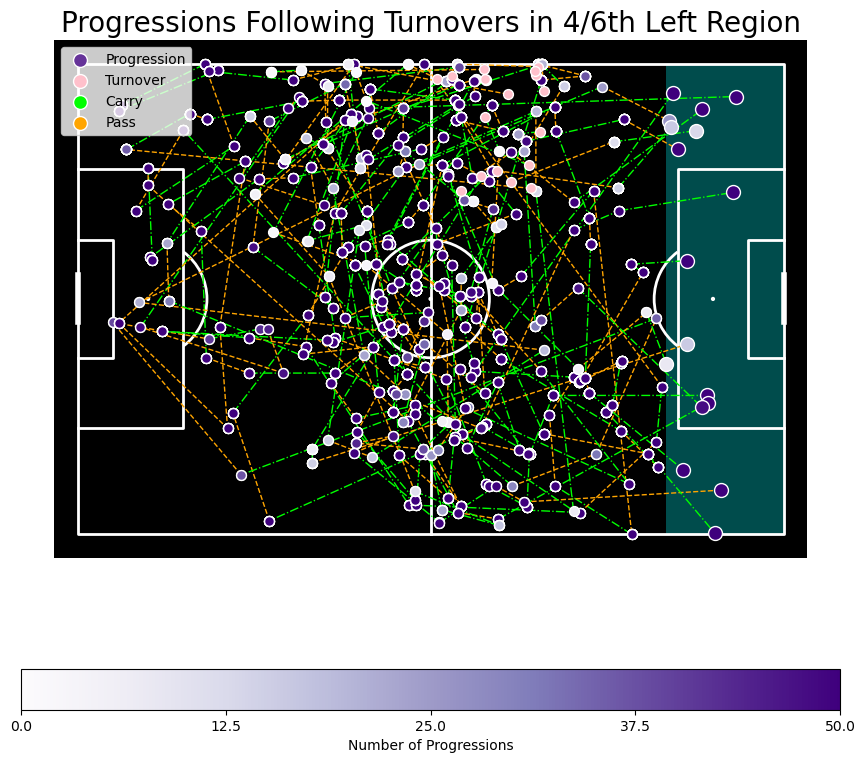

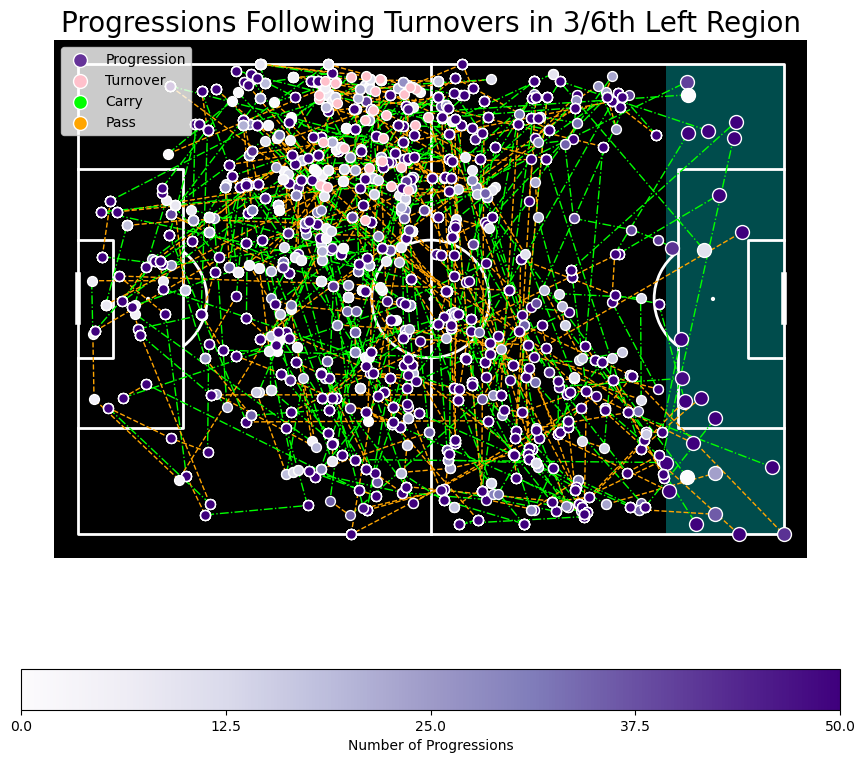

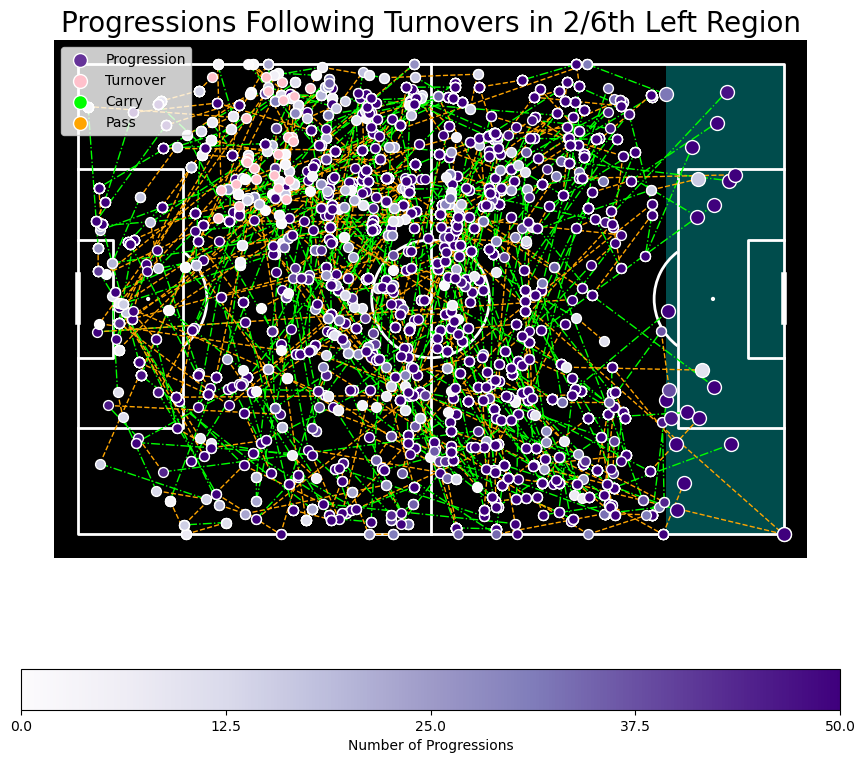

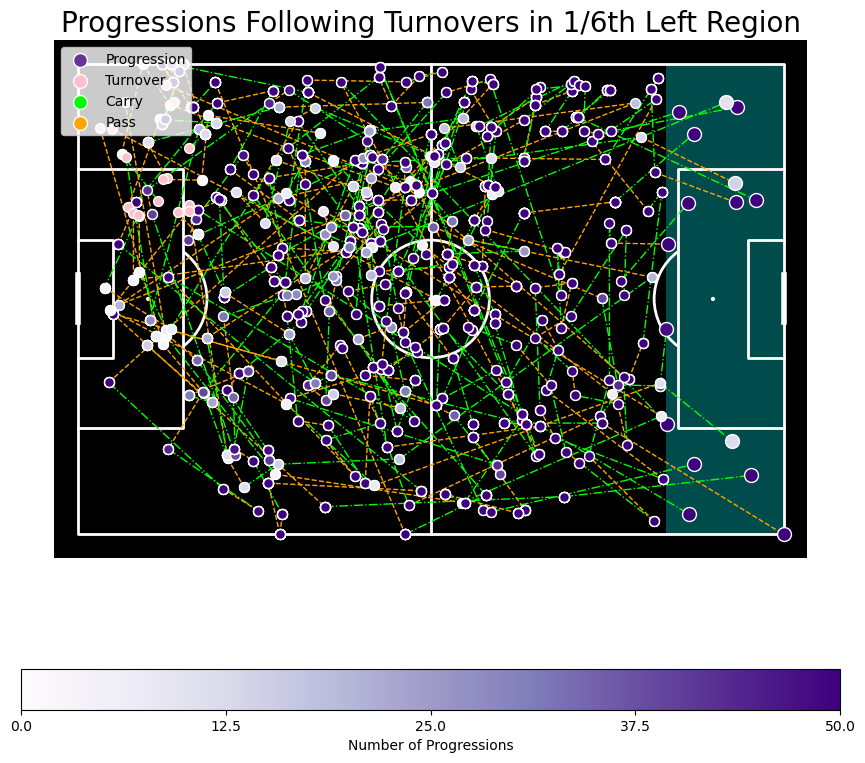

In [16]:
# Apply 4/6ths Left Region Filter
progression_4_6th_left = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (60 <= row[0] < 80) and
                    (0 <= row[1] < 80/3)
    )
]

plot_turnover_progression(progression_4_6th_left, "4/6th Left Region")

# Apply 3/6ths Left Region Filter 
progression_3_6th_left = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (40 <= row[0] < 60) and
                    (0 <= row[1] < 80/3)
    )
]

plot_turnover_progression(progression_3_6th_left, "3/6th Left Region")

# Apply 2/6ths Left Region Filter 
progression_2_6th_left = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (20 <= row[0] < 40) and
                    (0 <= row[1] < 80/3)
    )
]

plot_turnover_progression(progression_2_6th_left, "2/6th Left Region")

# Apply 1/6ths Left Region Filter 
progression_1_6th_left = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (0 <= row[0] < 20) and
                    (0 <= row[1] < 80/3)
    )
]

plot_turnover_progression(progression_1_6th_left, "1/6th Left Region")

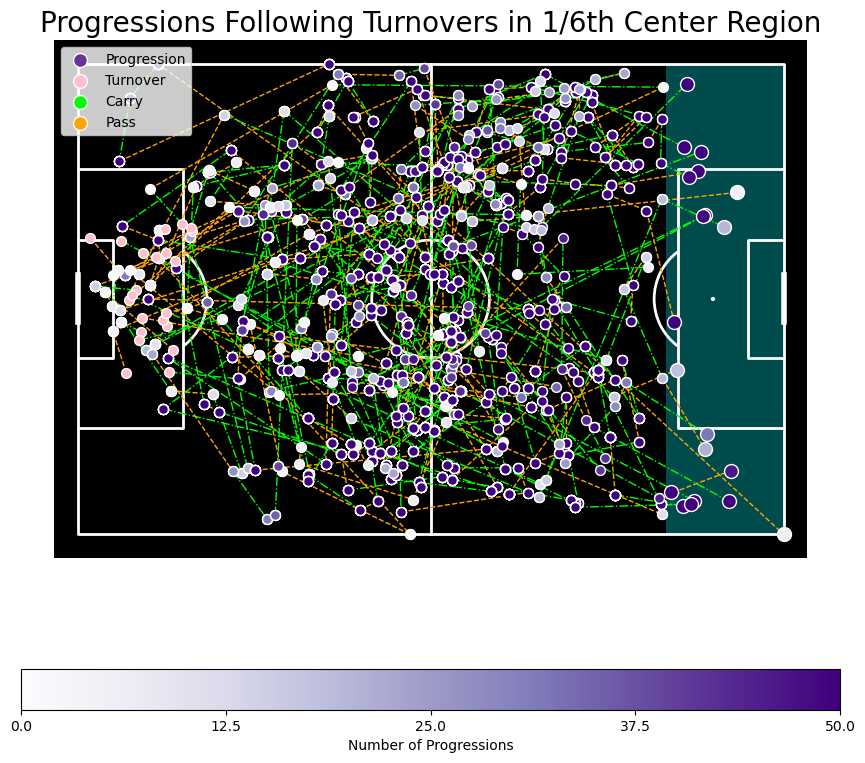

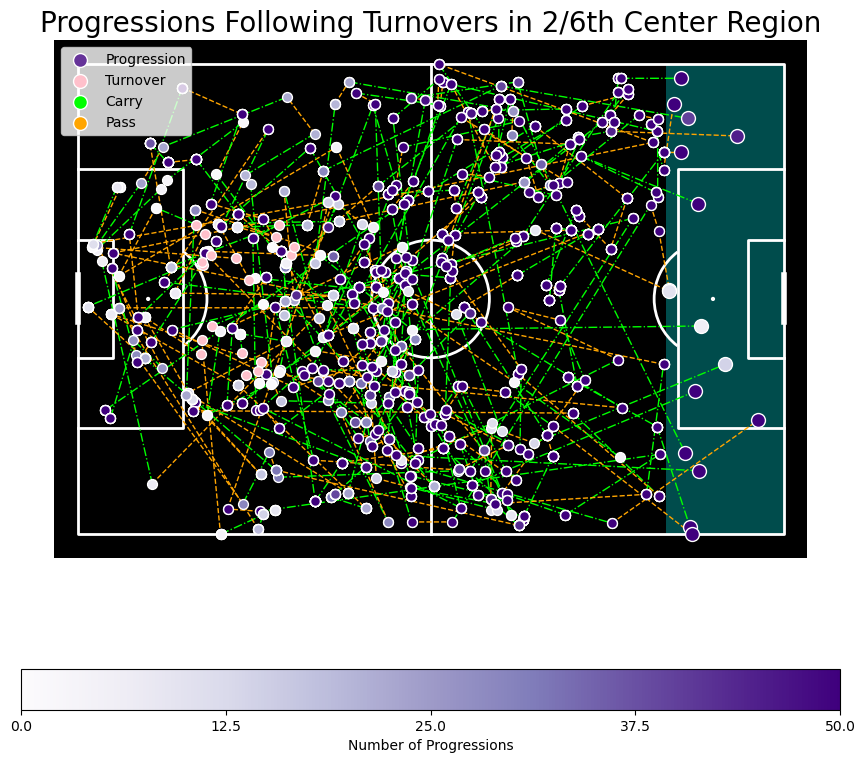

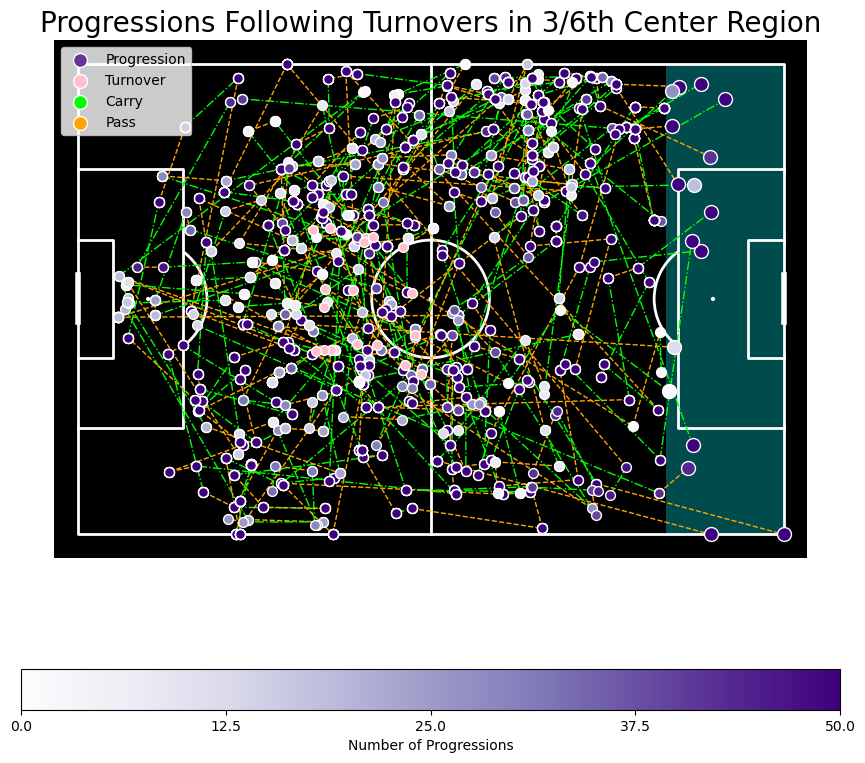

In [17]:
# Apply 1/6ths Center Region Filter 
progression_1_6th_center = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (0 <= row[0] < 20) and
                    (80/3 <= row[1] < 160/3)
    )
]

plot_turnover_progression(progression_1_6th_center, "1/6th Center Region")

# Apply 2/6ths Center Region Filter 
progression_2_6th_center = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (20 <= row[0] < 40) and
                    (80/3 <= row[1] < 160/3)
    )
]

plot_turnover_progression(progression_2_6th_center, "2/6th Center Region")

# Apply 3/6ths Center Region Filter 
progression_3_6th_center = progression_merged_df[
    progression_merged_df["location_turnover"].apply(
        lambda row: isinstance(row, list) and
                    (40 <= row[0] < 60) and
                    (80/3 <= row[1] < 160/3)
    )
]

plot_turnover_progression(progression_3_6th_center, "3/6th Center Region")

In [18]:
# POSSESSION SWITCHES 
opp_turnover_events_df = opp_turnover_events_df.rename(columns={"timestamp_seconds": "timestamp_seconds_lost_pos"})

bayer_and_opp_turnover_df = pd.merge_asof(
    turnover_events_df,
    opp_turnover_events_df,
    left_on = "timestamp_seconds_turnover",
    right_on = "timestamp_seconds_lost_pos",
    by = "match_id",
    direction = "forward",
    suffixes = ("_gain_pos", "_lost_pos")
)

bayer_and_opp_turnover_df = bayer_and_opp_turnover_df.sort_values(["timestamp_seconds_turnover", "match_id"])
bayer_and_opp_turnover_df.reset_index(drop = True, inplace = True)

# Assign each turnover to both the next turnover to the opposition AND the final sixth progression 
opp_turnover_final_sixths_df = pd.merge_asof(
    bayer_and_opp_turnover_df,
    progression_events_final_sixth_df,
    left_on = "timestamp_seconds_turnover",
    right_on = "timestamp_seconds_progression",
    by = "match_id",
    direction = "forward"
)

opp_turnover_final_sixths_df = opp_turnover_final_sixths_df.sort_values(["timestamp_seconds_turnover", "match_id"])
opp_turnover_final_sixths_df.reset_index(drop = True, inplace = True)

# opp_turnover_final_sixths_df[["match_id", "timestamp_seconds_turnover", "timestamp_seconds_progression", "timestamp_seconds_lost_pos"]].head(50)
# list(opp_turnover_final_sixths_df.columns)


In [19]:
# X FEATURE CREATION
# NUMBER OF PASSES AND CARRIES PER TURNOVER SEQUENCE
# NUMBER OF PASSES FOR EACH TURNOVER SEQUENCE

def calculate_num_passes(row, passes_df):
    match_id = row["match_id"]
    timestamp_seconds_turnover = row["timestamp_seconds_turnover"]
    timestamp_seconds_lost_pos = row["timestamp_seconds_lost_pos"]

    # Filter passes_df for the specific match_id and time interval
    passes_in_interval = passes_df[
        (passes_df["match_id"] == match_id) &
        (passes_df["timestamp_seconds"] > timestamp_seconds_turnover) &
        (passes_df["timestamp_seconds"] <= timestamp_seconds_lost_pos)
    ]
    # Return the count of passes in the interval
    return len(passes_in_interval)

# Apply the function to each row of opp_turnover_final_sixths_df
opp_turnover_final_sixths_df["num_passes_per_turnover"] = opp_turnover_final_sixths_df.apply(
    lambda row: calculate_num_passes(row, passes_df), axis=1
)

# NUMBER OF CARRIES FOR EACH TURNOVER SEQUENCE
def calculate_num_carrys(row, carrys_df):
    match_id = row["match_id"]
    timestamp_seconds_turnover = row["timestamp_seconds_turnover"]
    timestamp_seconds_lost_pos = row["timestamp_seconds_lost_pos"]
    carrys_in_interval = carrys_df[
        (carrys_df["match_id"] == match_id) &
        (carrys_df["timestamp_seconds"] > timestamp_seconds_turnover) &
        (carrys_df["timestamp_seconds"] <= timestamp_seconds_lost_pos)
    ]
    return len(carrys_in_interval)
opp_turnover_final_sixths_df["num_carrys_per_turnover"] = opp_turnover_final_sixths_df.apply(
    lambda row: calculate_num_carrys(row, passes_df), axis=1
)
# SEQUENCE TIME 
opp_turnover_final_sixths_df["sequence_time"] = opp_turnover_final_sixths_df["timestamp_seconds_lost_pos"] - opp_turnover_final_sixths_df["timestamp_seconds_turnover"] 

# HORIZONTAL COOORDINATE EXTACTION
opp_turnover_final_sixths_df[["x_turnover", "y_turnover"]] = pd.DataFrame(
    opp_turnover_final_sixths_df["location_gain_pos"].tolist(), index = opp_turnover_final_sixths_df.index
)

opp_turnover_final_sixths_df = opp_turnover_final_sixths_df[
    (opp_turnover_final_sixths_df["x_turnover"] >= 0) & 
    (opp_turnover_final_sixths_df["x_turnover"] < 100)
]

In [20]:
# CONVERT VERTICAL COORDINATE TO TRI ZONE
def assign_vertical_zone(y):
    if 0 <= y < 80/3: 
        return "left"
    elif 80/3 <= y < 160/3: 
        return "center"
    else:
        return "right"

opp_turnover_final_sixths_df["y_zone"] = opp_turnover_final_sixths_df["y_turnover"].apply(assign_vertical_zone)

# opp_turnover_final_sixths_df[["match_id", "timestamp_seconds_turnover", "sequence_time", "num_passes_per_turnover", "num_carrys_per_turnover", "x_turnover", "x_zone", "y_turnover", "turnover_type_gain_pos"]].head(50)

# ONE HOT ENCODING FOR VERTICAL ZONE OF TURNOVER
full_turnover_final_sixths_df = pd.get_dummies(
    opp_turnover_final_sixths_df, 
    columns=["y_zone"], 
    drop_first=True  # Since we're going for logistical regression -> this is best if you want to avoid collinearity
)

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, log_loss
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
import seaborn as sns


In [22]:
# X AND Y Target Variable: After each turnover -> we are tracking if it enters the final sixth before they lose possession 
full_turnover_final_sixths_df["enters_final_sixth"] = np.where(
    full_turnover_final_sixths_df["timestamp_seconds_lost_pos"] > full_turnover_final_sixths_df["timestamp_seconds_progression"], 1, 0)

Y = full_turnover_final_sixths_df["enters_final_sixth"]

X = full_turnover_final_sixths_df[[
    "sequence_time",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_passes_per_turnover",
    "num_carrys_per_turnover"
]]

X_clean = X.dropna()
Y_clean = Y.loc[X_clean.index]

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

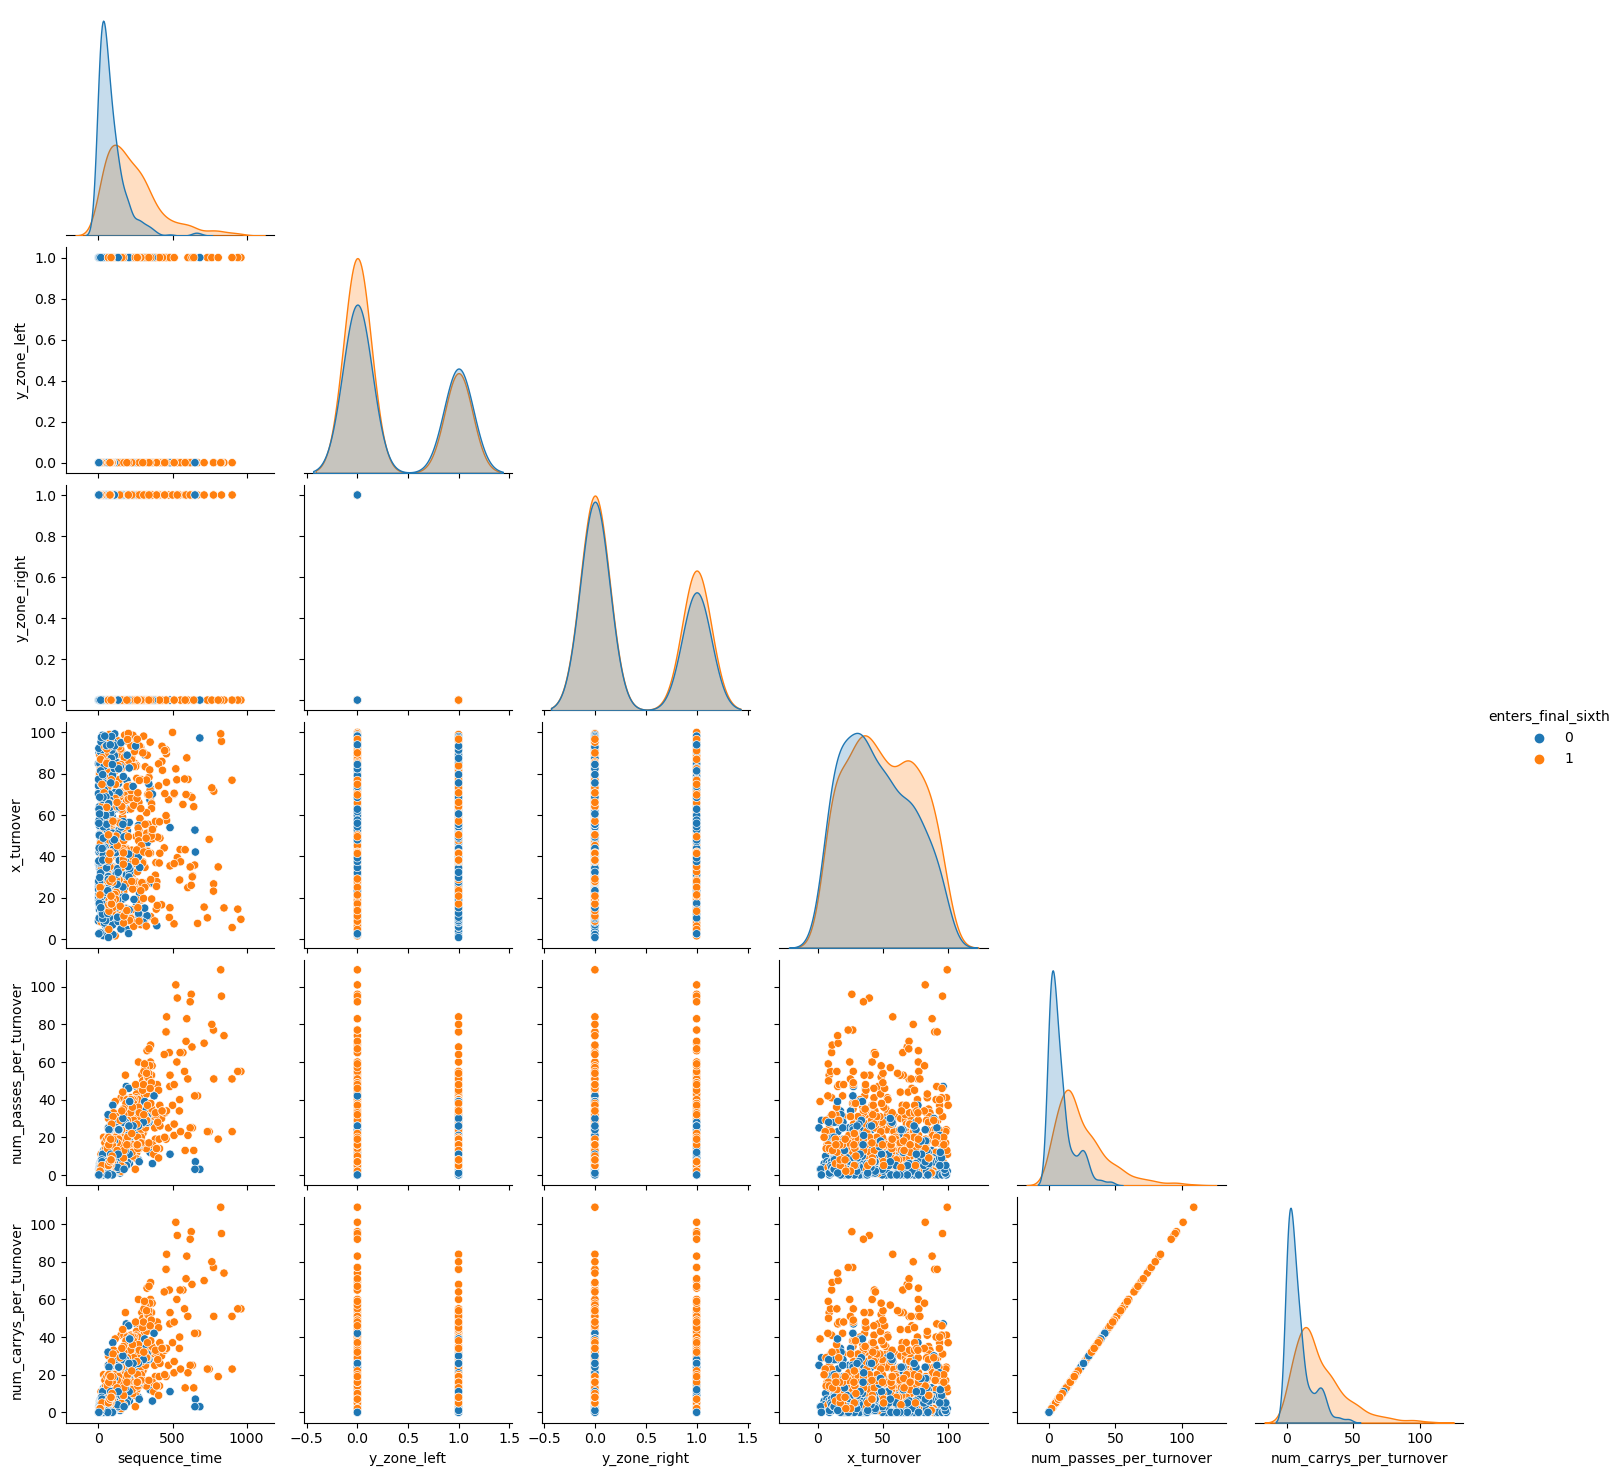

In [23]:
# Pair Plot (Scatter Matrix to detect collinearity)
sns.pairplot(pd.concat([X_clean, Y_clean], axis=1), hue="enters_final_sixth", diag_kind="kde", corner = True)
plt.show()

Accuracy: 0.7542857142857143
Precision: 0.7926829268292683
Recall: 0.7142857142857143
F1 Score: 0.7514450867052024
AUC-ROC: 0.8175039246467818
Log Loss: 0.5271740280226341
L2 Regularization Coefficients:
                   Feature  Coefficient
0            sequence_time     3.209668
1              y_zone_left    -0.308045
2             y_zone_right    -0.150954
3               x_turnover     0.619803
4  num_passes_per_turnover     2.845550
5  num_carrys_per_turnover     2.845550
L1 Regularization Coefficients:
                   Feature  Coefficient
0            sequence_time     3.908757
1              y_zone_left    -0.298994
2             y_zone_right    -0.133026
3               x_turnover     0.538455
4  num_passes_per_turnover     5.394001
5  num_carrys_per_turnover     1.096893


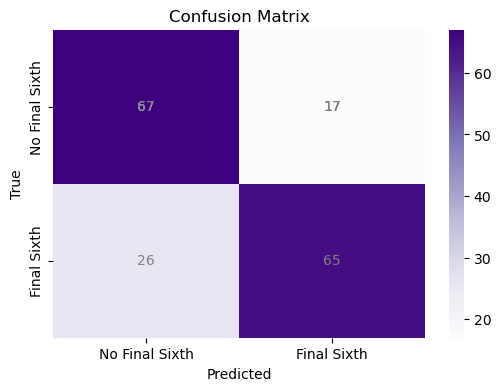

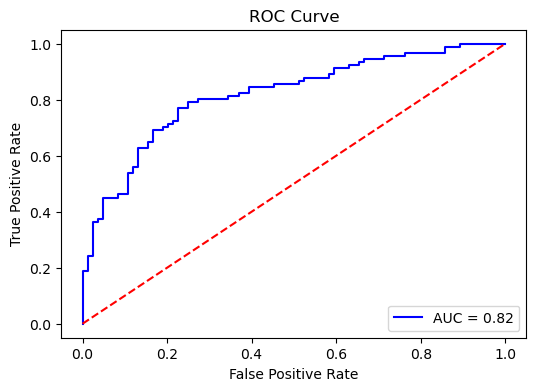

Cross-Validation Accuracy Scores: [0.73142857 0.70285714 0.68390805 0.72988506 0.79310345]
Standard Deviation: 0.03695876525374321
CV Mean Accuracy: 0.7282
CV Mean Precision: 0.7640
CV Mean Recall: 0.6916
CV Mean F1 Score: 0.7260
CV Mean AUC-ROC: 0.8040
CV Mean Log Loss: 0.5400


In [24]:
# LOGISTIC REGRESSION PIPELINE 

def run_logistic_regression(X, Y):
    # Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 6, stratify = Y)

    # Normalization: All columns excluding 'y_zone_left' and 'y_zone_right'
    columns_to_normalize = [col for col in X_train.columns if col not in ['y_zone_left', 'y_zone_right']] # This is literally my fav line of code ever

    scaler = MinMaxScaler()
    X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
    X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

    # Pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Apply MinMaxScaler to all columns by default in the pipeline
        ('model', LogisticRegression(random_state=6))  # Logistic regression model
    ])

    # Train and Predict
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    Y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Key Metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Accuracy: {accuracy}")
    
    precision = precision_score(Y_test, Y_pred)
    print(f"Precision: {precision}")
    
    recall = recall_score(Y_test, Y_pred)
    print(f"Recall: {recall}")
    
    f1 = f1_score(Y_test, Y_pred)
    print(f"F1 Score: {f1}")
    
    roc_auc = roc_auc_score(Y_test, Y_pred_proba)
    print(f"AUC-ROC: {roc_auc}")
    
    log_loss_value = log_loss(Y_test, Y_pred_proba)
    print(f"Log Loss: {log_loss_value}")
    
    # FEATURE SELECTION AND COEFFICIENT ANALYSIS 
    log_reg_l2 = LogisticRegression(penalty='l2', random_state=6)
    log_reg_l2.fit(X_train, Y_train)
    
    # L2
    coef_l2 = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': log_reg_l2.coef_[0]
    })
    
    print("L2 Regularization Coefficients:")
    print(coef_l2)
    
    # L1
    log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=6)
    log_reg_l1.fit(X_train, Y_train)
    
    coef_l1 = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': log_reg_l1.coef_[0]
    })
    
    print("L1 Regularization Coefficients:")
    print(coef_l1)

    # Confusion Matrix
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["No Final Sixth", "Final Sixth"], yticklabels=["No Final Sixth", "Final Sixth"])
    
    # Add annotations manually
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='grey')
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # AUC-ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 5-FOLD CROSS VALIDATION
    kfold = KFold(n_splits=5, shuffle=True, random_state=6)
    
    pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(random_state=6))
    ])
    
    # Cross-validation accuracy scores
    cv_acc_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring="accuracy")
    
    print("Cross-Validation Accuracy Scores:", cv_acc_scores)
    print("Standard Deviation:", cv_acc_scores.std())
    
    # Predictions with cross-validation
    Y_pred_cv = cross_val_predict(pipeline, X, Y, cv=kfold)
    Y_pred_proba_cv = cross_val_predict(pipeline, X, Y, cv=kfold, method="predict_proba")[:, 1]
    
    # Cross-validation metrics
    accuracy_cv = accuracy_score(Y, Y_pred_cv)
    precision_cv = precision_score(Y, Y_pred_cv)
    recall_cv = recall_score(Y, Y_pred_cv)
    f1_cv = f1_score(Y, Y_pred_cv)
    roc_auc_cv = roc_auc_score(Y, Y_pred_proba_cv)
    log_loss_cv = log_loss(Y, Y_pred_proba_cv)
    
    print(f"CV Mean Accuracy: {accuracy_cv:.4f}")
    print(f"CV Mean Precision: {precision_cv:.4f}")
    print(f"CV Mean Recall: {recall_cv:.4f}")
    print(f"CV Mean F1 Score: {f1_cv:.4f}")
    print(f"CV Mean AUC-ROC: {roc_auc_cv:.4f}")
    print(f"CV Mean Log Loss: {log_loss_cv:.4f}")

run_logistic_regression(X_clean, Y_clean)

Accuracy: 0.7485714285714286
Precision: 0.7422680412371134
Recall: 0.7912087912087912
F1 Score: 0.7659574468085107
AUC-ROC: 0.8133176347462062
Log Loss: 0.5258981855291132
L2 Regularization Coefficients:
                   Feature  Coefficient
0        sequence_time_log     3.527304
1              y_zone_left    -0.265098
2             y_zone_right    -0.110418
3               x_turnover     0.657132
4  num_passes_per_turnover     2.520022
5  num_carrys_per_turnover     2.520022
L1 Regularization Coefficients:
                   Feature  Coefficient
0        sequence_time_log     3.930635
1              y_zone_left    -0.248070
2             y_zone_right    -0.084514
3               x_turnover     0.579621
4  num_passes_per_turnover     5.410722
5  num_carrys_per_turnover     0.253905


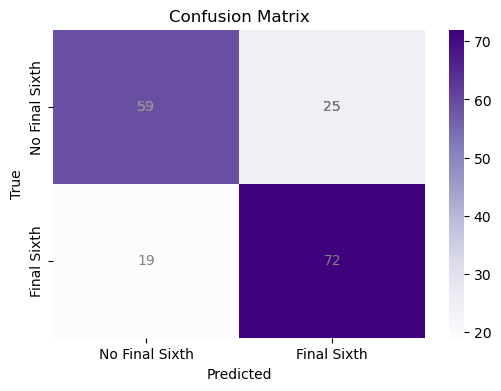

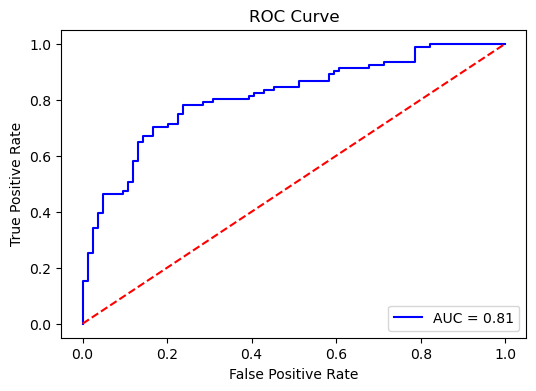

Cross-Validation Accuracy Scores: [0.72571429 0.70857143 0.70114943 0.72988506 0.7816092 ]
Standard Deviation: 0.028183481748592462
CV Mean Accuracy: 0.7294
CV Mean Precision: 0.7422
CV Mean Recall: 0.7357
CV Mean F1 Score: 0.7389
CV Mean AUC-ROC: 0.8053
CV Mean Log Loss: 0.5334


In [25]:
# 2nd Logistical Regression Model: Log transformation on sequence_time (variance stabilization)
full_turnover_final_sixths_df["sequence_time_log"] = np.log(full_turnover_final_sixths_df["sequence_time"] + 1)
X_2 = full_turnover_final_sixths_df[[
    "sequence_time_log",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_passes_per_turnover",
    "num_carrys_per_turnover"
]]

X_2_clean = X_2.dropna()
Y_2_clean = Y.loc[X_2_clean.index]

run_logistic_regression(X_2_clean, Y_2_clean)

In [26]:
# 3rd Logistical Regression Model: Prepping features

# Number of progressive passes 
# Number of crosses and switches 
# Number of progressive carries 

# Progressive Pass: A pass that advances the ball at least 10 meters (in the opponent’s half) or 30 meters (in your own half) toward the opponent's goal. 
# For passes that cross the halfway line, they need to move the ball at least 15 meters closer to the opponent's goal.
passes_df[["x_pass_start", "y_pass_start"]] = pd.DataFrame(
    passes_df["location"].tolist(), index = passes_df.index
)

passes_df[["x_pass_end", "y_pass_end"]] = pd.DataFrame(
    passes_df["pass_end_location"].tolist(), index = passes_df.index
)

def filter_progressive_passes(passes_df):
    pass_hor_distance = passes_df["x_pass_end"] - passes_df["x_pass_start"]
    condition_1 = ((0 < passes_df["x_pass_start"]) & (passes_df["x_pass_start"] <= 60) & 
                   (0 < passes_df["x_pass_end"]) & (passes_df["x_pass_end"] <= 60) & 
                   (pass_hor_distance >= 30))
    condition_2 = ((0 < passes_df["x_pass_start"]) & (passes_df["x_pass_start"] <= 60) & 
                  (60 < passes_df["x_pass_end"]) & (passes_df["x_pass_end"] <= 120) & 
                  (pass_hor_distance >= 15))
    condition_3 = ((60 < passes_df["x_pass_start"]) & (passes_df["x_pass_start"] <= 120) & 
                  (60 < passes_df["x_pass_end"]) & (passes_df["x_pass_end"] <= 120) & 
                  (pass_hor_distance >= 10))
    return passes_df[condition_1 | condition_2 | condition_3]
    
progressive_passes_df = filter_progressive_passes(passes_df)
full_turnover_final_sixths_df["num_progressive_passes_per_turnover"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_passes (row, progressive_passes_df), axis=1
)

# full_turnover_final_sixths_df[["num_passes_per_turnover", "num_progressive_passes_per_turnover"]].head(50)

# Crosses and Switches
def filter_switch_cross(passes_df):
    return passes_df[(passes_df["pass_switch"] == True) | (passes_df["pass_cross"] == True)]
switch_cross_df = filter_switch_cross(passes_df)
full_turnover_final_sixths_df["num_switch_cross_per_turnover"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_passes (row, switch_cross_df), axis = 1
)

# Progressive Carry: A carry that moves the ball at least 5 meters closer to the opponent's goal, whether in the team’s own half or the opposition's half.
carrys_df[["x_carry_start", "y_carry_start"]] = pd.DataFrame(
    carrys_df["location"].tolist(), index = carrys_df.index
)

carrys_df[["x_carry_end", "y_carry_end"]] = pd.DataFrame(
    carrys_df["carry_end_location"].tolist(), index = carrys_df.index
)

def filter_progressive_carrys(carrys_df):
    carry_hor_distance = carrys_df["x_carry_end"] - carrys_df["x_carry_start"]
    return carrys_df[carry_hor_distance >= 5]
progressive_carrys_df = filter_progressive_carrys(carrys_df)
full_turnover_final_sixths_df["num_progressive_carrys_per_turnover"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_carrys (row, progressive_carrys_df), axis = 1
)

Accuracy: 0.7771428571428571
Precision: 0.7954545454545454
Recall: 0.7692307692307693
F1 Score: 0.782122905027933
AUC-ROC: 0.8536106750392465
Log Loss: 0.47486619044296796
L2 Regularization Coefficients:
                               Feature  Coefficient
0                    sequence_time_log     3.043951
1                          y_zone_left    -0.315699
2                         y_zone_right    -0.115089
3                           x_turnover     0.686719
4  num_progressive_passes_per_turnover     4.024746
5        num_switch_cross_per_turnover     1.037990
6  num_progressive_carrys_per_turnover     4.080913
L1 Regularization Coefficients:
                               Feature  Coefficient
0                    sequence_time_log     2.105015
1                          y_zone_left    -0.400158
2                         y_zone_right    -0.134179
3                           x_turnover     0.658524
4  num_progressive_passes_per_turnover     9.522847
5        num_switch_cross_per_turnov

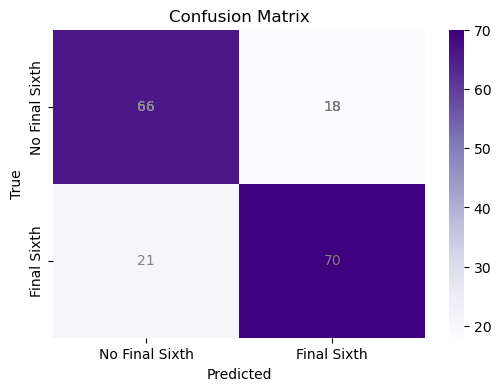

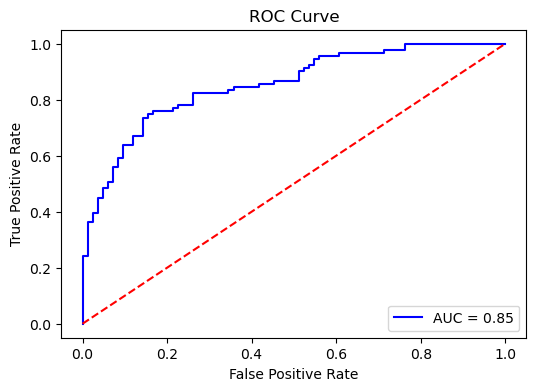

Cross-Validation Accuracy Scores: [0.76571429 0.73714286 0.76436782 0.74137931 0.82183908]
Standard Deviation: 0.03019808704116364
CV Mean Accuracy: 0.7661
CV Mean Precision: 0.7921
CV Mean Recall: 0.7467
CV Mean F1 Score: 0.7687
CV Mean AUC-ROC: 0.8508
CV Mean Log Loss: 0.4849


In [27]:
# 3rd Logistical Regression Model: Replacing num_passes and num_carrys with more specific metrics
X_3 = full_turnover_final_sixths_df[[
    "sequence_time_log",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_progressive_passes_per_turnover",
    "num_switch_cross_per_turnover",
    "num_progressive_carrys_per_turnover"
]]

X_3_clean = X_3.dropna()
Y_3_clean = Y.loc[X_3_clean.index]

run_logistic_regression(X_3_clean, Y_3_clean)

Accuracy: 0.7828571428571428
Precision: 0.8192771084337349
Recall: 0.7472527472527473
F1 Score: 0.7816091954022989
AUC-ROC: 0.8744113029827315
Log Loss: 0.4425201273763599
L2 Regularization Coefficients:
                               Feature  Coefficient
0                    sequence_time_log     2.938025
1                          y_zone_left    -0.312502
2                         y_zone_right    -0.108039
3                           x_turnover     0.694155
4  num_progressive_passes_per_turnover     3.427985
5        num_switch_cross_per_turnover     0.806506
6  num_progressive_carrys_per_turnover     3.633852
7         num_progressive_passes_xhaka     1.829235
8            num_switch_cross_grimaldo     1.502656
9      num_progressive_carrys_frimpong     2.893830
L1 Regularization Coefficients:
                               Feature  Coefficient
0                    sequence_time_log     2.169874
1                          y_zone_left    -0.392546
2                         y_zone_rig

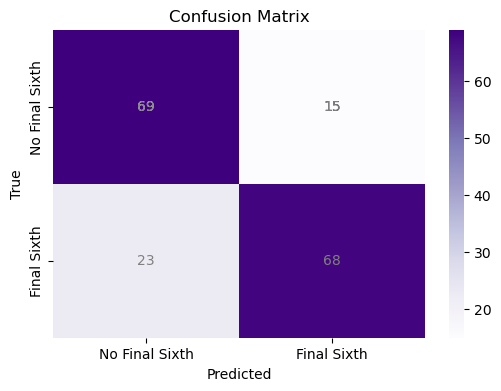

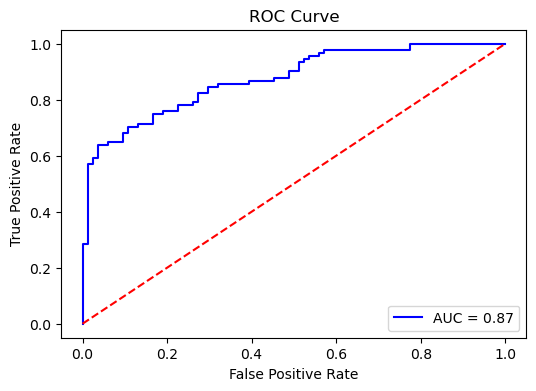

Cross-Validation Accuracy Scores: [0.78857143 0.77714286 0.79885057 0.76436782 0.82183908]
Standard Deviation: 0.019577008893967365
CV Mean Accuracy: 0.7901
CV Mean Precision: 0.8203
CV Mean Recall: 0.7643
CV Mean F1 Score: 0.7913
CV Mean AUC-ROC: 0.8689
CV Mean Log Loss: 0.4592


In [28]:
# 4th Logistical Regression Model: Player Specific Skillsets from EDA

# Number of progressive passes by Xhaka
xhaka_progressive_passes_df = progressive_passes_df[progressive_passes_df["player"] == "Granit Xhaka"]
full_turnover_final_sixths_df["num_progressive_passes_xhaka"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_passes (row, xhaka_progressive_passes_df), axis = 1
)
# Number of crosses and switches by Grimaldo
grimaldo_switch_cross_df = switch_cross_df[switch_cross_df["player"] == "Alejandro Grimaldo García"]
full_turnover_final_sixths_df["num_switch_cross_grimaldo"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_passes (row, grimaldo_switch_cross_df), axis = 1
)
# Number of progressive carries by Frimpong
frimpong_progressive_carrys_df = progressive_carrys_df[progressive_carrys_df["player"] == "Jeremie Frimpong"]
full_turnover_final_sixths_df["num_progressive_carrys_frimpong"] = full_turnover_final_sixths_df.apply(
    lambda row: calculate_num_carrys (row, frimpong_progressive_carrys_df), axis = 1
)

X_4 = full_turnover_final_sixths_df[[
    "sequence_time_log",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_progressive_passes_per_turnover",
    "num_switch_cross_per_turnover",
    "num_progressive_carrys_per_turnover",
    "num_progressive_passes_xhaka",
    "num_switch_cross_grimaldo",
    "num_progressive_carrys_frimpong"
]]

X_4_clean = X_4.dropna()
Y_4_clean = Y.loc[X_4_clean.index]

run_logistic_regression(X_4_clean, Y_4_clean)

Accuracy: 0.8285714285714286
Precision: 0.8351648351648352
Recall: 0.8351648351648352
F1 Score: 0.8351648351648353
AUC-ROC: 0.9109105180533752
Log Loss: 0.39441686919269514
L2 Regularization Coefficients:
                                Feature  Coefficient
0                     sequence_time_log     2.374571
1                           y_zone_left    -0.281975
2                          y_zone_right    -0.041115
3                            x_turnover     0.912373
4   num_progressive_passes_per_turnover     2.926287
5         num_switch_cross_per_turnover     0.589215
6   num_progressive_carrys_per_turnover     3.377839
7          num_progressive_passes_xhaka     1.791902
8             num_switch_cross_grimaldo     1.484246
9       num_progressive_carrys_frimpong     2.620836
10   average_prog_pass_dis_per_turnover     1.634082
11  average_prog_carry_dis_per_turnover     2.273495
L1 Regularization Coefficients:
                                Feature  Coefficient
0                    

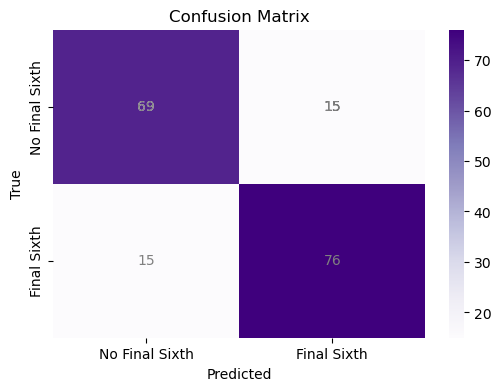

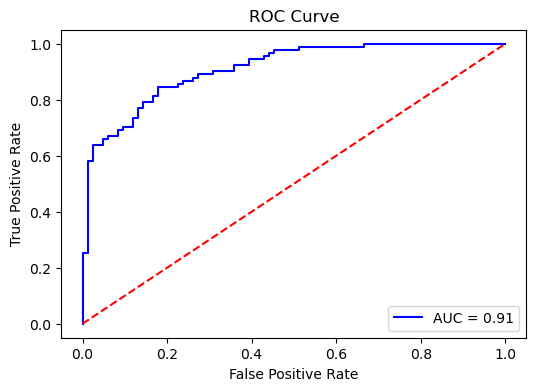

Cross-Validation Accuracy Scores: [0.77714286 0.76       0.84482759 0.77011494 0.82183908]
Standard Deviation: 0.032759843921999265
CV Mean Accuracy: 0.7947
CV Mean Precision: 0.7907
CV Mean Recall: 0.8238
CV Mean F1 Score: 0.8069
CV Mean AUC-ROC: 0.8832
CV Mean Log Loss: 0.4311


In [29]:
# 5th Logistical Regression Model: Average pass distance per turnover sequence FOR progressive passes and carrys
def get_distance(x_end, x_start, y_end, y_start):
    hor_dis = abs(x_end - x_start)
    vert_dis = abs(y_end - y_start)
    return np.sqrt(hor_dis**2 + vert_dis**2)

def average_distance(row, df, x_start_col, x_end_col, y_start_col, y_end_col):
    match_id = row["match_id"]
    timestamp_seconds_turnover = row["timestamp_seconds_turnover"]
    timestamp_seconds_lost_pos = row["timestamp_seconds_lost_pos"]

    # Filter actions within the turnover sequence
    action_in_interval = df[
        (df["match_id"] == match_id) &
        (df["timestamp_seconds"] > timestamp_seconds_turnover) &
        (df["timestamp_seconds"] <= timestamp_seconds_lost_pos)
    ]

    # Compute distances
    distances = action_in_interval.apply(
        lambda action_row: get_distance(
            action_row[x_end_col], action_row[x_start_col],
            action_row[y_end_col], action_row[y_start_col]
        ), axis=1
    )
    return distances.mean() if not distances.empty else 0

# For passes
full_turnover_final_sixths_df["average_prog_pass_dis_per_turnover"] = full_turnover_final_sixths_df.apply(
    lambda row: average_distance(row, progressive_passes_df, "x_pass_start", "x_pass_end", "y_pass_start", "y_pass_end"), axis=1
)

# For carries
full_turnover_final_sixths_df["average_prog_carry_dis_per_turnover"] = full_turnover_final_sixths_df.apply(
    lambda row: average_distance(row, progressive_carrys_df, "x_carry_start", "x_carry_end", "y_carry_start", "y_carry_end"), axis=1
)

X_5 = full_turnover_final_sixths_df[[
    "sequence_time_log",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_progressive_passes_per_turnover",
    "num_switch_cross_per_turnover",
    "num_progressive_carrys_per_turnover",
    "num_progressive_passes_xhaka",
    "num_switch_cross_grimaldo",
    "num_progressive_carrys_frimpong",
    "average_prog_pass_dis_per_turnover",
    "average_prog_carry_dis_per_turnover"
]]

X_5_clean = X_5.dropna()
Y_5_clean = Y.loc[X_5_clean.index]

run_logistic_regression(X_5_clean, Y_5_clean)

Accuracy: 0.8285714285714286
Precision: 0.8351648351648352
Recall: 0.8351648351648352
F1 Score: 0.8351648351648353
AUC-ROC: 0.9144427001569858
Log Loss: 0.38777168750136165
L2 Regularization Coefficients:
                                Feature  Coefficient
0                     sequence_time_log     2.447151
1                           y_zone_left    -0.265503
2                          y_zone_right    -0.050644
3                            x_turnover     0.956983
4   num_progressive_passes_per_turnover     2.799473
5   num_progressive_carrys_per_turnover     3.399514
6          num_progressive_passes_xhaka     1.250381
7             num_switch_cross_grimaldo     1.573306
8       num_progressive_carrys_frimpong     1.704638
9    average_prog_pass_dis_per_turnover     1.631896
10  average_prog_carry_dis_per_turnover     2.059510
11               distance_passing_xhaka     1.074626
12               explosiveness_frimpong     1.696218
L1 Regularization Coefficients:
                     

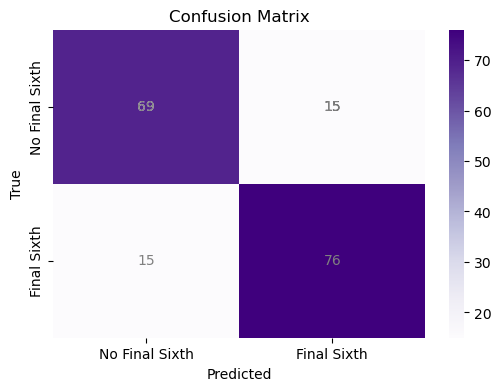

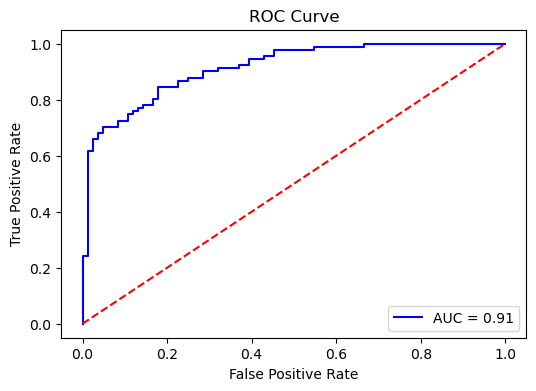

Cross-Validation Accuracy Scores: [0.77714286 0.74285714 0.83333333 0.77011494 0.81609195]
Standard Deviation: 0.03261857476046537
CV Mean Accuracy: 0.7878
CV Mean Precision: 0.7880
CV Mean Recall: 0.8106
CV Mean F1 Score: 0.7991
CV Mean AUC-ROC: 0.8840
CV Mean Log Loss: 0.4288


In [30]:
# 6th Logistical Regression Model: Interaction terms - Grimaldo's long distance passing, Xhaka's tempo control, Frimpong's explosiveness
full_turnover_final_sixths_df["long_passing_grimaldo"] = full_turnover_final_sixths_df["num_switch_cross_grimaldo"] * full_turnover_final_sixths_df["average_prog_pass_dis_per_turnover"] 
full_turnover_final_sixths_df["tempo_control_xhaka"] = full_turnover_final_sixths_df["num_progressive_passes_xhaka"] * full_turnover_final_sixths_df["sequence_time_log"]
full_turnover_final_sixths_df["distance_passing_xhaka"] = full_turnover_final_sixths_df["num_progressive_passes_xhaka"] * full_turnover_final_sixths_df["average_prog_pass_dis_per_turnover"] 
full_turnover_final_sixths_df["explosiveness_frimpong"] = full_turnover_final_sixths_df["num_progressive_carrys_frimpong"] * full_turnover_final_sixths_df["average_prog_carry_dis_per_turnover"]

X_6 = full_turnover_final_sixths_df[[
    "sequence_time_log",
    "y_zone_left",
    "y_zone_right",
    "x_turnover",
    "num_progressive_passes_per_turnover",
    # "num_switch_cross_per_turnover",
    "num_progressive_carrys_per_turnover",
    "num_progressive_passes_xhaka",
    "num_switch_cross_grimaldo",
    "num_progressive_carrys_frimpong",
    "average_prog_pass_dis_per_turnover",
    "average_prog_carry_dis_per_turnover",
    # "long_passing_grimaldo",
    # "tempo_control_xhaka",
    "distance_passing_xhaka",
    "explosiveness_frimpong"
]]

X_6_clean = X_6.dropna()
Y_6_clean = Y.loc[X_6_clean.index]

final_pipeline = run_logistic_regression(X_6_clean, Y_6_clean)

In [31]:
# Hyperparameter Tuning - No need to do anything, default values are optimal!
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear']  
}

logreg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_6_clean, Y_6_clean)

print("Best hyperparameters:", grid_search.best_params_)
print("Best AUC-ROC:", grid_search.best_score_)

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC-ROC: 0.8821251130459393


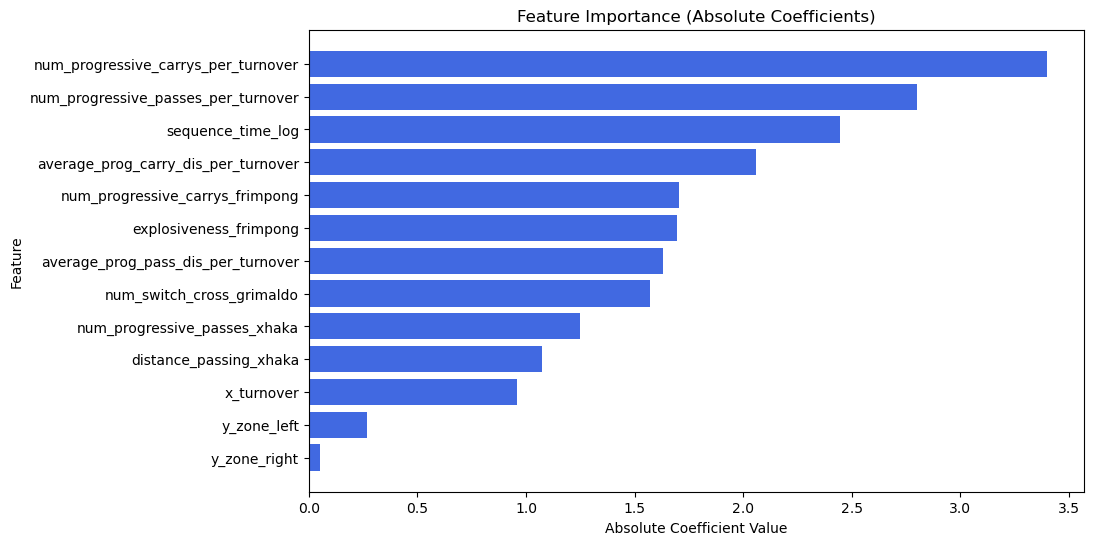

In [32]:
# Final Logistical Regression Final Model Visualizations

# Coefficient Plot
coefficients = np.array([2.447151, -0.265503, -0.050644, 0.956983, 2.799473, 3.399514, 
                         1.250381, 1.573306, 1.704638, 1.631896, 2.059510, 1.074626, 1.696218])
features = ["sequence_time_log", "y_zone_left", "y_zone_right", "x_turnover", 
            "num_progressive_passes_per_turnover", "num_progressive_carrys_per_turnover", 
            "num_progressive_passes_xhaka", "num_switch_cross_grimaldo", 
            "num_progressive_carrys_frimpong", "average_prog_pass_dis_per_turnover", 
            "average_prog_carry_dis_per_turnover", "distance_passing_xhaka", "explosiveness_frimpong"]

# Sort the coefficients by absolute value
sorted_idx = np.argsort(np.abs(coefficients))

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], np.abs(coefficients[sorted_idx]), color="royalblue")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Absolute Coefficients)")

# Show the plot
plt.show()

In [35]:
# OPTIONAL TODO: 7th Logistical Regression Model - Counterpressing and baiting the press